In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from modelutility_v2 import *


# define folder location
model_name = 'CNN_1.0_Pred_PVlog'
dir_path = os.getcwd()
data_folder = os.path.join(dir_path, "data_pred_expanded","frequency_2")
output_folder = os.path.join('models',model_name)

#define file location
image_log_trainval_path = os.path.join(data_folder,'image_log_trainval.npy')
pv_log_trainval_path = os.path.join(data_folder,'pv_log_trainval.npy')
pv_pred_trainval_path = os.path.join(data_folder,'pv_pred_trainval.npy')
times_trainval_path = os.path.join(data_folder,'times_trainval.npy')

image_log_test_path = os.path.join(data_folder,'image_log_test.npy')
pv_log_test_path = os.path.join(data_folder,'pv_log_test.npy')
pv_pred_test_path = os.path.join(data_folder,'pv_pred_test.npy')
times_test_path = os.path.join(data_folder,'times_test.npy')

first_cloudy_test = datetime.datetime(2018,2,18)

# define model characteristics
width = 24
filter_size = [3,3]
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 100
num_rep = 10
plotting = True
learning_rate = 3e-6
batch_size = 256

In [2]:
# The model
def cnn_33_model(X2, y, is_training):
#     # CBP sandwich 1
#     conv1 = tf.layers.conv2d(
#         inputs=X,
#         filters=width,
#         kernel_size=filter_size,
#         padding="same",
#         activation=tf.nn.relu)
#     bn1 = tf.layers.batch_normalization(inputs=conv1, axis= -1, training = is_training)
#     pool1 = tf.layers.max_pooling2d(inputs=bn1, pool_size=[2, 2], strides=2)

#     # CBP sandwich 2
#     conv3 = tf.layers.conv2d(
#         inputs=pool1,
#         filters=width*2,
#         kernel_size=filter_size,
#         padding="same",
#         activation=tf.nn.relu)
#     bn3 = tf.layers.batch_normalization(inputs=conv3, axis= -1,training = is_training)
#     pool2 = tf.layers.max_pooling2d(inputs=bn3, pool_size=[2, 2], strides=2)

#     down_rate = 4
        
    # Two fully connected nets
#     pool2_flat = tf.reshape(pool2, [-1, int(side_len/down_rate*side_len/down_rate*width*2)])
    pool2_flat_aug = X2
    
    dense1 = tf.layers.dense(inputs=pool2_flat_aug, units=dense_size, activation=tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs=dense1, rate=drop_rate, training = is_training)
    dense2 = tf.layers.dense(inputs=dropout1, units=dense_size, activation=tf.nn.relu)
    dropout2 = tf.layers.dropout(inputs=dense2, rate=drop_rate, training = is_training)
    
    regression = tf.layers.dense(inputs=dropout2, units=1)
    regression = tf.reshape(regression, [-1])
    return regression

In [3]:
# load PV output and images for the trainval set
pv_log_trainval = np.load(pv_log_trainval_path)
# images_trainval = np.load(image_log_trainval_path)
pv_pred_trainval = np.load(pv_pred_trainval_path)
times_trainval = np.load(times_trainval_path)

# stack up the history and colors into a unified channel
# images_trainval = images_trainval.transpose((0,2,3,4,1))
# images_trainval = images_trainval.reshape((images_trainval.shape[0],
#                                            images_trainval.shape[1],images_trainval.shape[2],-1))

# shuffling of the data by day
shuffled_indices = day_block_shuffle(times_trainval)
pv_log_trainval = pv_log_trainval[shuffled_indices]
pv_pred_trainval = pv_pred_trainval[shuffled_indices]
times_trainval = times_trainval[shuffled_indices]
# images_trainval = images_trainval[shuffled_indices]

# Input dimension is used to construct the model
# side_len = images_trainval.shape[1]
# image_input_dim = [side_len,side_len,images_trainval.shape[3]]

In [4]:
# Build computational graph
tf.reset_default_graph()  # Reset computational graph

# x,y, pred_y 
#x_var = tf.placeholder(tf.float32, [None, side_len, side_len, images_trainval.shape[3]])  # x variable
x2_var = tf.placeholder(tf.float32, [None, pv_log_trainval.shape[1]])
y_var = tf.placeholder(tf.float32, [None])  # y variable
is_training = tf.placeholder(tf.bool) # a flag

pred_y_var = cnn_33_model(x2_var, y_var, is_training)  # model in use

# loss and other accuracy indicator
loss_var = tf.losses.mean_squared_error(y_var, pred_y_var)  # loss in use
y_var_std = tf.reduce_mean(tf.square(y_var-tf.reduce_mean(y_var)))
rel_err_var = tf.sqrt(tf.divide(loss_var, y_var_std))

# Define optimizer and optimize session parameter
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
# update_ops consist of calculating running average
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# make sure every time during training the moving average is updated
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(loss_var)
pass

Training
Iteration 0: with minibatch training loss = 302 and relative error of 2
Iteration 20: with minibatch training loss = 227 and relative error of 1.7
Iteration 40: with minibatch training loss = 185 and relative error of 1.6
Iteration 60: with minibatch training loss = 158 and relative error of 1.4
Iteration 80: with minibatch training loss = 118 and relative error of 1.3
Iteration 100: with minibatch training loss = 111 and relative error of 1.2
Iteration 120: with minibatch training loss = 95.1 and relative error of 1.1
Iteration 140: with minibatch training loss = 68.5 and relative error of 0.93
Iteration 160: with minibatch training loss = 55.8 and relative error of 0.83
Iteration 180: with minibatch training loss = 46.5 and relative error of 0.76
Iteration 200: with minibatch training loss = 39.4 and relative error of 0.73
Iteration 220: with minibatch training loss = 27.8 and relative error of 0.61
Iteration 240: with minibatch training loss = 26.3 and relative error of 0.5

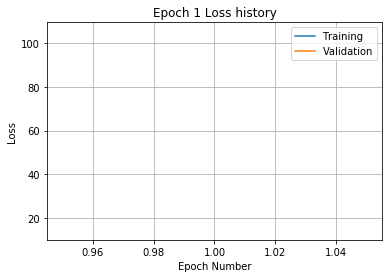

Training
Iteration 0: with minibatch training loss = 23.6 and relative error of 0.55
Iteration 20: with minibatch training loss = 27.9 and relative error of 0.59
Iteration 40: with minibatch training loss = 17.3 and relative error of 0.47
Iteration 60: with minibatch training loss = 18.4 and relative error of 0.5
Iteration 80: with minibatch training loss = 15.7 and relative error of 0.44
Iteration 100: with minibatch training loss = 18.9 and relative error of 0.49
Iteration 120: with minibatch training loss = 16.7 and relative error of 0.45
Iteration 140: with minibatch training loss = 14.2 and relative error of 0.42
Iteration 160: with minibatch training loss = 21 and relative error of 0.51
Iteration 180: with minibatch training loss = 14.5 and relative error of 0.42
Iteration 200: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 220: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 240: with minibatch training loss = 14.7 and relative 

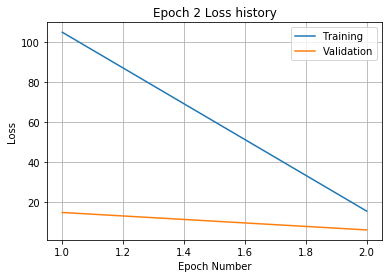

Training
Iteration 0: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 20: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 40: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 60: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 80: with minibatch training loss = 10.4 and relative error of 0.39
Iteration 100: with minibatch training loss = 14 and relative error of 0.4
Iteration 120: with minibatch training loss = 12.4 and relative error of 0.39
Iteration 140: with minibatch training loss = 13.1 and relative error of 0.4
Iteration 160: with minibatch training loss = 13 and relative error of 0.41
Iteration 180: with minibatch training loss = 12.8 and relative error of 0.4
Iteration 200: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 220: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 240: with minibatch training loss = 11.8 and relative error

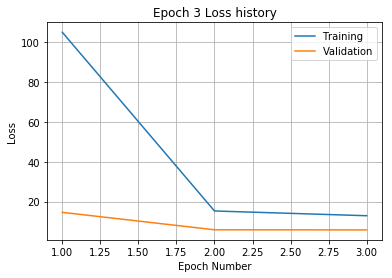

Training
Iteration 0: with minibatch training loss = 12.8 and relative error of 0.41
Iteration 20: with minibatch training loss = 12.9 and relative error of 0.43
Iteration 40: with minibatch training loss = 12.6 and relative error of 0.4
Iteration 60: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 80: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 100: with minibatch training loss = 14.5 and relative error of 0.43
Iteration 120: with minibatch training loss = 13.5 and relative error of 0.42
Iteration 140: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 160: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 180: with minibatch training loss = 13.1 and relative error of 0.43
Iteration 200: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 220: with minibatch training loss = 12.7 and relative error of 0.4
Iteration 240: with minibatch training loss = 10.4 and relative 

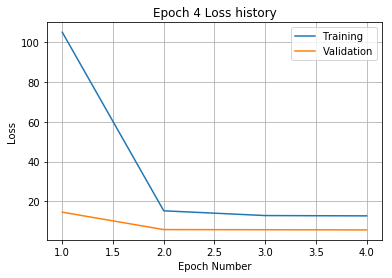

Training
Iteration 0: with minibatch training loss = 13.6 and relative error of 0.42
Iteration 20: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 40: with minibatch training loss = 8.77 and relative error of 0.33
Iteration 60: with minibatch training loss = 13 and relative error of 0.42
Iteration 80: with minibatch training loss = 16 and relative error of 0.43
Iteration 100: with minibatch training loss = 11.3 and relative error of 0.37
Iteration 120: with minibatch training loss = 9.81 and relative error of 0.35
Iteration 140: with minibatch training loss = 12.5 and relative error of 0.39
Iteration 160: with minibatch training loss = 12.3 and relative error of 0.39
Iteration 180: with minibatch training loss = 11.7 and relative error of 0.41
Iteration 200: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 220: with minibatch training loss = 14.5 and relative error of 0.42
Iteration 240: with minibatch training loss = 11.1 and relative e

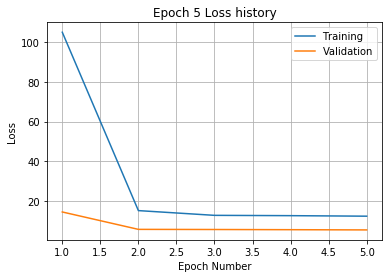

Training
Iteration 0: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 20: with minibatch training loss = 12.8 and relative error of 0.41
Iteration 40: with minibatch training loss = 14.6 and relative error of 0.43
Iteration 60: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 80: with minibatch training loss = 11.3 and relative error of 0.36
Iteration 100: with minibatch training loss = 12.2 and relative error of 0.39
Iteration 120: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 140: with minibatch training loss = 12.3 and relative error of 0.39
Iteration 160: with minibatch training loss = 13.6 and relative error of 0.41
Iteration 180: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 200: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 220: with minibatch training loss = 11.1 and relative error of 0.4
Iteration 240: with minibatch training loss = 12.2 and relative

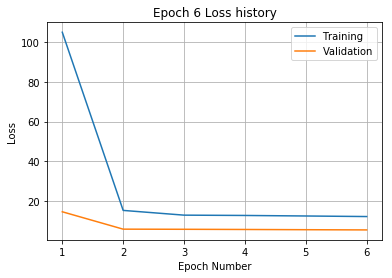

Training
Iteration 0: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 20: with minibatch training loss = 13.6 and relative error of 0.4
Iteration 40: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 60: with minibatch training loss = 13.2 and relative error of 0.42
Iteration 80: with minibatch training loss = 13.3 and relative error of 0.42
Iteration 100: with minibatch training loss = 9.93 and relative error of 0.36
Iteration 120: with minibatch training loss = 12.2 and relative error of 0.41
Iteration 140: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 160: with minibatch training loss = 14.3 and relative error of 0.44
Iteration 180: with minibatch training loss = 13.6 and relative error of 0.43
Iteration 200: with minibatch training loss = 13.1 and relative error of 0.42
Iteration 220: with minibatch training loss = 11 and relative error of 0.37
Iteration 240: with minibatch training loss = 14.2 and relative 

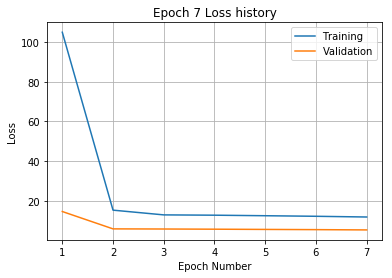

Training
Iteration 0: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 20: with minibatch training loss = 14 and relative error of 0.4
Iteration 40: with minibatch training loss = 12.8 and relative error of 0.4
Iteration 60: with minibatch training loss = 15.9 and relative error of 0.46
Iteration 80: with minibatch training loss = 11 and relative error of 0.37
Iteration 100: with minibatch training loss = 12.1 and relative error of 0.4
Iteration 120: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 140: with minibatch training loss = 11.2 and relative error of 0.37
Iteration 160: with minibatch training loss = 11.9 and relative error of 0.38
Iteration 180: with minibatch training loss = 11 and relative error of 0.37
Iteration 200: with minibatch training loss = 12.6 and relative error of 0.4
Iteration 220: with minibatch training loss = 11.2 and relative error of 0.39
Iteration 240: with minibatch training loss = 11.8 and relative error o

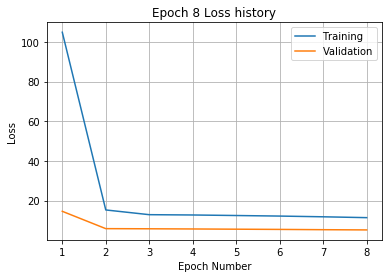

Training
Iteration 0: with minibatch training loss = 13.3 and relative error of 0.4
Iteration 20: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 40: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 60: with minibatch training loss = 8.34 and relative error of 0.33
Iteration 80: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 100: with minibatch training loss = 12.6 and relative error of 0.42
Iteration 120: with minibatch training loss = 10 and relative error of 0.37
Iteration 140: with minibatch training loss = 9.28 and relative error of 0.34
Iteration 160: with minibatch training loss = 10.4 and relative error of 0.37
Iteration 180: with minibatch training loss = 9.37 and relative error of 0.35
Iteration 200: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 220: with minibatch training loss = 14.5 and relative error of 0.44
Iteration 240: with minibatch training loss = 10.9 and relative e

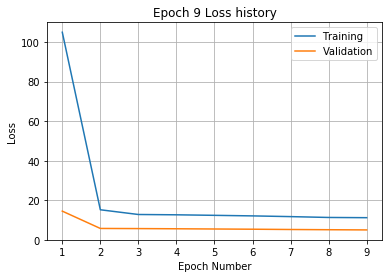

Training
Iteration 0: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 20: with minibatch training loss = 9.7 and relative error of 0.35
Iteration 40: with minibatch training loss = 13.1 and relative error of 0.42
Iteration 60: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 80: with minibatch training loss = 12 and relative error of 0.39
Iteration 100: with minibatch training loss = 10.5 and relative error of 0.38
Iteration 120: with minibatch training loss = 9.19 and relative error of 0.34
Iteration 140: with minibatch training loss = 9.83 and relative error of 0.36
Iteration 160: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 180: with minibatch training loss = 10.4 and relative error of 0.39
Iteration 200: with minibatch training loss = 11.5 and relative error of 0.37
Iteration 220: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 240: with minibatch training loss = 9.23 and relative 

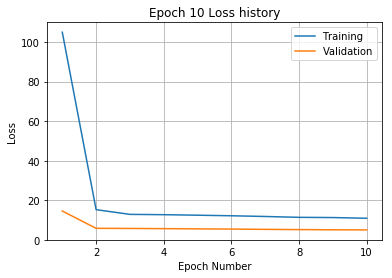

Training
Iteration 0: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 20: with minibatch training loss = 8.29 and relative error of 0.32
Iteration 40: with minibatch training loss = 13.3 and relative error of 0.41
Iteration 60: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 80: with minibatch training loss = 12.2 and relative error of 0.39
Iteration 100: with minibatch training loss = 12.9 and relative error of 0.4
Iteration 120: with minibatch training loss = 12.2 and relative error of 0.39
Iteration 140: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 160: with minibatch training loss = 9.35 and relative error of 0.35
Iteration 180: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 200: with minibatch training loss = 9.19 and relative error of 0.35
Iteration 220: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 240: with minibatch training loss = 12.3 and relativ

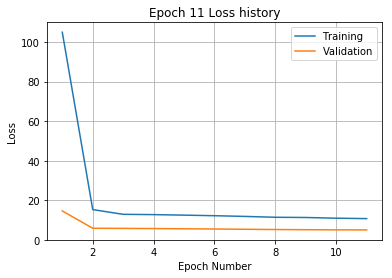

Training
Iteration 0: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 20: with minibatch training loss = 14.3 and relative error of 0.44
Iteration 40: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 60: with minibatch training loss = 9.56 and relative error of 0.35
Iteration 80: with minibatch training loss = 9.7 and relative error of 0.37
Iteration 100: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 120: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 140: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 160: with minibatch training loss = 13.3 and relative error of 0.41
Iteration 180: with minibatch training loss = 6.71 and relative error of 0.29
Iteration 200: with minibatch training loss = 12.1 and relative error of 0.38
Iteration 220: with minibatch training loss = 7.9 and relative error of 0.32
Iteration 240: with minibatch training loss = 10.9 and relative

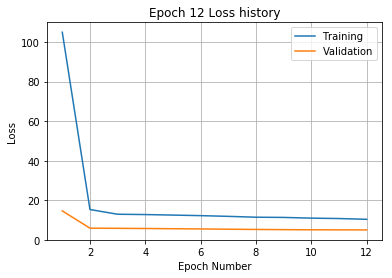

Training
Iteration 0: with minibatch training loss = 11.2 and relative error of 0.39
Iteration 20: with minibatch training loss = 7.62 and relative error of 0.32
Iteration 40: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 60: with minibatch training loss = 8.71 and relative error of 0.33
Iteration 80: with minibatch training loss = 12 and relative error of 0.38
Iteration 100: with minibatch training loss = 9.97 and relative error of 0.37
Iteration 120: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 140: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 160: with minibatch training loss = 9.92 and relative error of 0.38
Iteration 180: with minibatch training loss = 8.71 and relative error of 0.33
Iteration 200: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 220: with minibatch training loss = 9.51 and relative error of 0.35
Iteration 240: with minibatch training loss = 10.4 and relative 

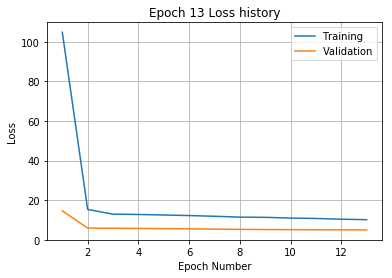

Training
Iteration 0: with minibatch training loss = 13 and relative error of 0.4
Iteration 20: with minibatch training loss = 12.9 and relative error of 0.41
Iteration 40: with minibatch training loss = 10.1 and relative error of 0.37
Iteration 60: with minibatch training loss = 8.4 and relative error of 0.33
Iteration 80: with minibatch training loss = 9.42 and relative error of 0.35
Iteration 100: with minibatch training loss = 10.4 and relative error of 0.37
Iteration 120: with minibatch training loss = 6.86 and relative error of 0.31
Iteration 140: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 160: with minibatch training loss = 9.53 and relative error of 0.35
Iteration 180: with minibatch training loss = 7.81 and relative error of 0.32
Iteration 200: with minibatch training loss = 8.87 and relative error of 0.35
Iteration 220: with minibatch training loss = 11 and relative error of 0.37
Iteration 240: with minibatch training loss = 8.04 and relative err

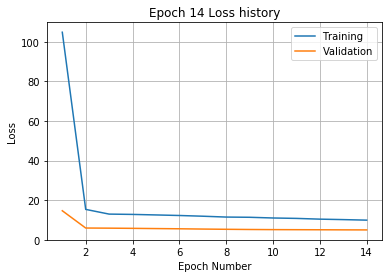

Training
Iteration 0: with minibatch training loss = 6.93 and relative error of 0.29
Iteration 20: with minibatch training loss = 9.59 and relative error of 0.34
Iteration 40: with minibatch training loss = 9.16 and relative error of 0.36
Iteration 60: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 80: with minibatch training loss = 7.98 and relative error of 0.31
Iteration 100: with minibatch training loss = 6.84 and relative error of 0.29
Iteration 120: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 140: with minibatch training loss = 9.85 and relative error of 0.35
Iteration 160: with minibatch training loss = 13.5 and relative error of 0.42
Iteration 180: with minibatch training loss = 8.19 and relative error of 0.33
Iteration 200: with minibatch training loss = 10 and relative error of 0.35
Iteration 220: with minibatch training loss = 8.7 and relative error of 0.32
Iteration 240: with minibatch training loss = 8.39 and relative 

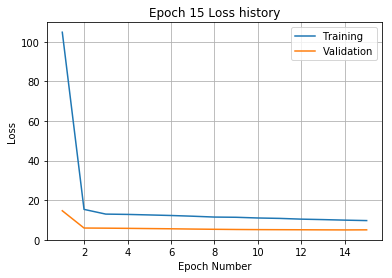

Training
Iteration 0: with minibatch training loss = 8.53 and relative error of 0.33
Iteration 20: with minibatch training loss = 8.74 and relative error of 0.34
Iteration 40: with minibatch training loss = 9.44 and relative error of 0.34
Iteration 60: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 80: with minibatch training loss = 7.64 and relative error of 0.31
Iteration 100: with minibatch training loss = 10.8 and relative error of 0.36
Iteration 120: with minibatch training loss = 8.98 and relative error of 0.34
Iteration 140: with minibatch training loss = 9.26 and relative error of 0.34
Iteration 160: with minibatch training loss = 12.6 and relative error of 0.4
Iteration 180: with minibatch training loss = 8.24 and relative error of 0.32
Iteration 200: with minibatch training loss = 9.52 and relative error of 0.35
Iteration 220: with minibatch training loss = 8.61 and relative error of 0.32
Iteration 240: with minibatch training loss = 12.8 and relativ

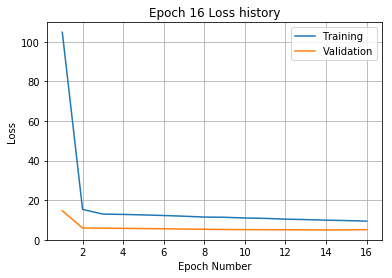

Training
Iteration 0: with minibatch training loss = 8.12 and relative error of 0.32
Iteration 20: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 40: with minibatch training loss = 9.97 and relative error of 0.36
Iteration 60: with minibatch training loss = 7.62 and relative error of 0.31
Iteration 80: with minibatch training loss = 16.1 and relative error of 0.46
Iteration 100: with minibatch training loss = 9.42 and relative error of 0.35
Iteration 120: with minibatch training loss = 8.39 and relative error of 0.34
Iteration 140: with minibatch training loss = 5.71 and relative error of 0.27
Iteration 160: with minibatch training loss = 8.92 and relative error of 0.33
Iteration 180: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 200: with minibatch training loss = 9.54 and relative error of 0.36
Iteration 220: with minibatch training loss = 9.03 and relative error of 0.34
Iteration 240: with minibatch training loss = 8.9 and relative

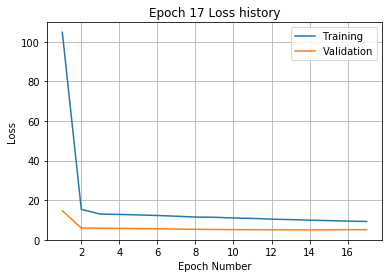

Training
Iteration 0: with minibatch training loss = 7.4 and relative error of 0.3
Iteration 20: with minibatch training loss = 8.6 and relative error of 0.34
Iteration 40: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 60: with minibatch training loss = 8.39 and relative error of 0.33
Iteration 80: with minibatch training loss = 7 and relative error of 0.29
Iteration 100: with minibatch training loss = 6.89 and relative error of 0.3
Iteration 120: with minibatch training loss = 8.5 and relative error of 0.34
Iteration 140: with minibatch training loss = 6.56 and relative error of 0.29
Iteration 160: with minibatch training loss = 12.5 and relative error of 0.39
Iteration 180: with minibatch training loss = 9.52 and relative error of 0.37
Iteration 200: with minibatch training loss = 9.45 and relative error of 0.34
Iteration 220: with minibatch training loss = 6.7 and relative error of 0.3
Iteration 240: with minibatch training loss = 9.9 and relative error of

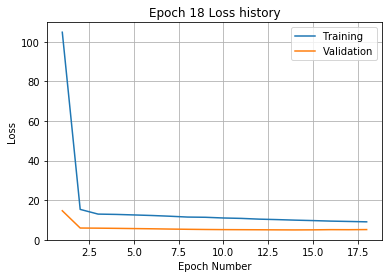

Training
Iteration 0: with minibatch training loss = 7.42 and relative error of 0.3
Iteration 20: with minibatch training loss = 8.98 and relative error of 0.34
Iteration 40: with minibatch training loss = 7.43 and relative error of 0.3
Iteration 60: with minibatch training loss = 7.38 and relative error of 0.31
Iteration 80: with minibatch training loss = 9.58 and relative error of 0.36
Iteration 100: with minibatch training loss = 7.05 and relative error of 0.3
Iteration 120: with minibatch training loss = 7.65 and relative error of 0.32
Iteration 140: with minibatch training loss = 8.19 and relative error of 0.33
Iteration 160: with minibatch training loss = 6.9 and relative error of 0.29
Iteration 180: with minibatch training loss = 7.79 and relative error of 0.31
Iteration 200: with minibatch training loss = 8.38 and relative error of 0.32
Iteration 220: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 240: with minibatch training loss = 6.74 and relative er

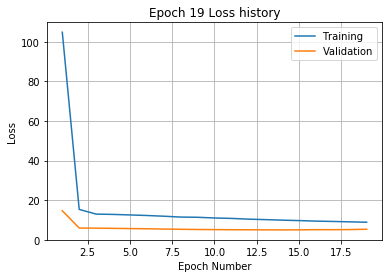

Validation error has stopped improving! Training on repetition 1 stopped!
Training
Iteration 0: with minibatch training loss = 196 and relative error of 1.6
Iteration 20: with minibatch training loss = 160 and relative error of 1.4
Iteration 40: with minibatch training loss = 127 and relative error of 1.3
Iteration 60: with minibatch training loss = 124 and relative error of 1.3
Iteration 80: with minibatch training loss = 90 and relative error of 1.1
Iteration 100: with minibatch training loss = 66.5 and relative error of 0.93
Iteration 120: with minibatch training loss = 61.3 and relative error of 0.9
Iteration 140: with minibatch training loss = 44.6 and relative error of 0.76
Iteration 160: with minibatch training loss = 35.1 and relative error of 0.67
Iteration 180: with minibatch training loss = 28 and relative error of 0.62
Iteration 200: with minibatch training loss = 25.9 and relative error of 0.57
Iteration 220: with minibatch training loss = 20.7 and relative error of 0.51
I

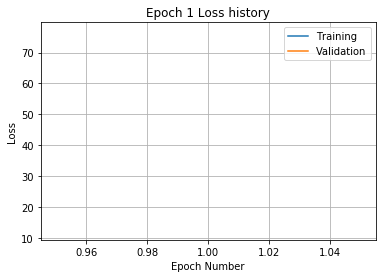

Training
Iteration 0: with minibatch training loss = 22.5 and relative error of 0.52
Iteration 20: with minibatch training loss = 18.2 and relative error of 0.49
Iteration 40: with minibatch training loss = 15.6 and relative error of 0.44
Iteration 60: with minibatch training loss = 13.4 and relative error of 0.43
Iteration 80: with minibatch training loss = 14.7 and relative error of 0.44
Iteration 100: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 120: with minibatch training loss = 14.3 and relative error of 0.41
Iteration 140: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 160: with minibatch training loss = 13.6 and relative error of 0.41
Iteration 180: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 200: with minibatch training loss = 17.1 and relative error of 0.47
Iteration 220: with minibatch training loss = 13.1 and relative error of 0.42
Iteration 240: with minibatch training loss = 11.2 and relati

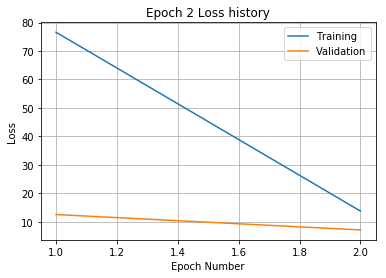

Training
Iteration 0: with minibatch training loss = 11.6 and relative error of 0.4
Iteration 20: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 40: with minibatch training loss = 13.1 and relative error of 0.4
Iteration 60: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 80: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 100: with minibatch training loss = 12.4 and relative error of 0.39
Iteration 120: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 140: with minibatch training loss = 14.4 and relative error of 0.43
Iteration 160: with minibatch training loss = 14.2 and relative error of 0.42
Iteration 180: with minibatch training loss = 15.4 and relative error of 0.46
Iteration 200: with minibatch training loss = 14.4 and relative error of 0.43
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 240: with minibatch training loss = 14.6 and relative

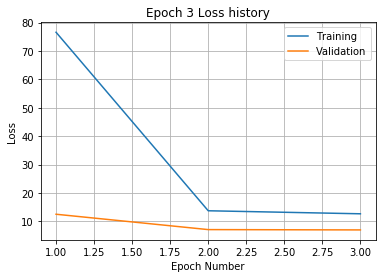

Training
Iteration 0: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 20: with minibatch training loss = 13.2 and relative error of 0.44
Iteration 40: with minibatch training loss = 11.6 and relative error of 0.37
Iteration 60: with minibatch training loss = 14.4 and relative error of 0.43
Iteration 80: with minibatch training loss = 13.4 and relative error of 0.41
Iteration 100: with minibatch training loss = 14.2 and relative error of 0.44
Iteration 120: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 140: with minibatch training loss = 12.8 and relative error of 0.42
Iteration 160: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 180: with minibatch training loss = 14 and relative error of 0.42
Iteration 200: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 220: with minibatch training loss = 12.8 and relative error of 0.4
Iteration 240: with minibatch training loss = 12.9 and relative 

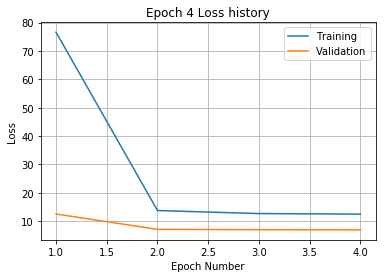

Training
Iteration 0: with minibatch training loss = 9.29 and relative error of 0.33
Iteration 20: with minibatch training loss = 11.2 and relative error of 0.39
Iteration 40: with minibatch training loss = 14.4 and relative error of 0.43
Iteration 60: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 80: with minibatch training loss = 9.73 and relative error of 0.34
Iteration 100: with minibatch training loss = 13 and relative error of 0.4
Iteration 120: with minibatch training loss = 13.6 and relative error of 0.42
Iteration 140: with minibatch training loss = 13.4 and relative error of 0.41
Iteration 160: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 180: with minibatch training loss = 10.5 and relative error of 0.38
Iteration 200: with minibatch training loss = 17.6 and relative error of 0.48
Iteration 220: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 240: with minibatch training loss = 11.1 and relative 

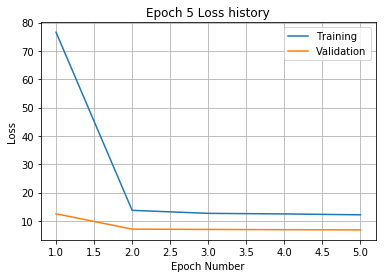

Training
Iteration 0: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 20: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 40: with minibatch training loss = 13.1 and relative error of 0.4
Iteration 60: with minibatch training loss = 11 and relative error of 0.37
Iteration 80: with minibatch training loss = 12.2 and relative error of 0.42
Iteration 100: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 120: with minibatch training loss = 11.8 and relative error of 0.38
Iteration 140: with minibatch training loss = 9.94 and relative error of 0.36
Iteration 160: with minibatch training loss = 8.98 and relative error of 0.35
Iteration 180: with minibatch training loss = 10.7 and relative error of 0.38
Iteration 200: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 220: with minibatch training loss = 12.2 and relative error of 0.39
Iteration 240: with minibatch training loss = 12.1 and relative 

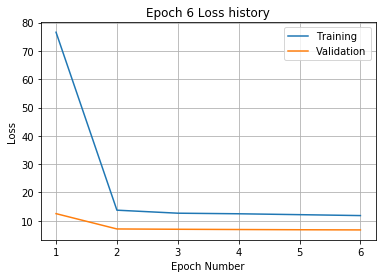

Training
Iteration 0: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 20: with minibatch training loss = 13 and relative error of 0.41
Iteration 40: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 60: with minibatch training loss = 9.9 and relative error of 0.34
Iteration 80: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 100: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 120: with minibatch training loss = 15.8 and relative error of 0.45
Iteration 140: with minibatch training loss = 11.9 and relative error of 0.38
Iteration 160: with minibatch training loss = 17 and relative error of 0.46
Iteration 180: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 200: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 220: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 240: with minibatch training loss = 12.4 and relative err

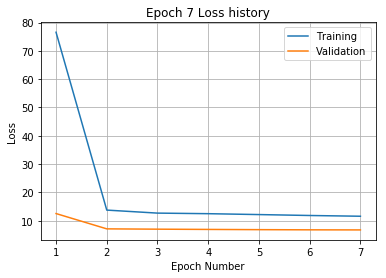

Training
Iteration 0: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 20: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 40: with minibatch training loss = 9.37 and relative error of 0.34
Iteration 60: with minibatch training loss = 12.9 and relative error of 0.41
Iteration 80: with minibatch training loss = 13.2 and relative error of 0.41
Iteration 100: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 120: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 140: with minibatch training loss = 12.3 and relative error of 0.38
Iteration 160: with minibatch training loss = 12.5 and relative error of 0.38
Iteration 180: with minibatch training loss = 9.41 and relative error of 0.35
Iteration 200: with minibatch training loss = 14.7 and relative error of 0.46
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 240: with minibatch training loss = 12.5 and relativ

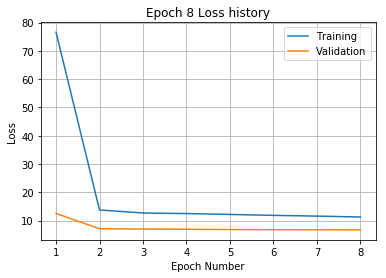

Training
Iteration 0: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 20: with minibatch training loss = 12.7 and relative error of 0.4
Iteration 40: with minibatch training loss = 10.8 and relative error of 0.36
Iteration 60: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 80: with minibatch training loss = 11 and relative error of 0.37
Iteration 100: with minibatch training loss = 12.1 and relative error of 0.4
Iteration 120: with minibatch training loss = 13.2 and relative error of 0.41
Iteration 140: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 160: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 180: with minibatch training loss = 10.7 and relative error of 0.38
Iteration 200: with minibatch training loss = 12.1 and relative error of 0.41
Iteration 220: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 240: with minibatch training loss = 12.9 and relative e

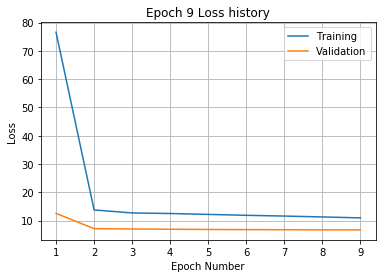

Training
Iteration 0: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 20: with minibatch training loss = 8.7 and relative error of 0.32
Iteration 40: with minibatch training loss = 13.5 and relative error of 0.42
Iteration 60: with minibatch training loss = 9.08 and relative error of 0.33
Iteration 80: with minibatch training loss = 9.5 and relative error of 0.35
Iteration 100: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 120: with minibatch training loss = 11 and relative error of 0.38
Iteration 140: with minibatch training loss = 13 and relative error of 0.39
Iteration 160: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 180: with minibatch training loss = 13 and relative error of 0.41
Iteration 200: with minibatch training loss = 7.84 and relative error of 0.31
Iteration 220: with minibatch training loss = 7.57 and relative error of 0.32
Iteration 240: with minibatch training loss = 8.63 and relative error

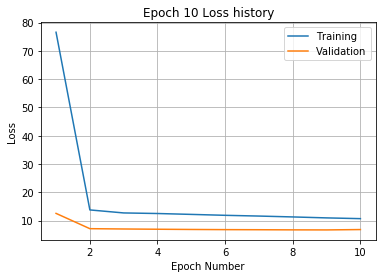

Training
Iteration 0: with minibatch training loss = 8.29 and relative error of 0.32
Iteration 20: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 40: with minibatch training loss = 10.3 and relative error of 0.35
Iteration 60: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 80: with minibatch training loss = 10 and relative error of 0.36
Iteration 100: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 120: with minibatch training loss = 7.97 and relative error of 0.33
Iteration 140: with minibatch training loss = 8.9 and relative error of 0.34
Iteration 160: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 180: with minibatch training loss = 8.34 and relative error of 0.34
Iteration 200: with minibatch training loss = 13.9 and relative error of 0.42
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 240: with minibatch training loss = 9.2 and relative e

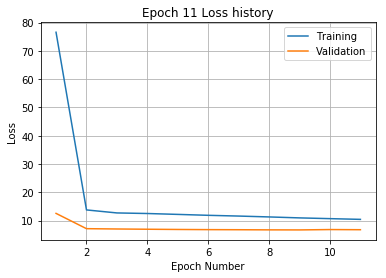

Training
Iteration 0: with minibatch training loss = 12.4 and relative error of 0.4
Iteration 20: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 40: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 60: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 80: with minibatch training loss = 13.7 and relative error of 0.43
Iteration 100: with minibatch training loss = 11.2 and relative error of 0.39
Iteration 120: with minibatch training loss = 9.98 and relative error of 0.35
Iteration 140: with minibatch training loss = 11 and relative error of 0.38
Iteration 160: with minibatch training loss = 8.2 and relative error of 0.31
Iteration 180: with minibatch training loss = 7.76 and relative error of 0.32
Iteration 200: with minibatch training loss = 9.53 and relative error of 0.35
Iteration 220: with minibatch training loss = 8.92 and relative error of 0.35
Iteration 240: with minibatch training loss = 7.23 and relative er

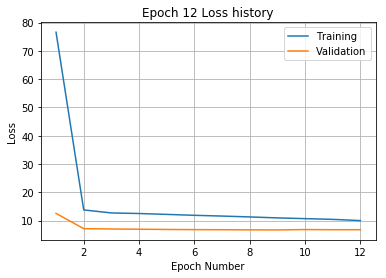

Training
Iteration 0: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 20: with minibatch training loss = 9.46 and relative error of 0.35
Iteration 40: with minibatch training loss = 9.32 and relative error of 0.34
Iteration 60: with minibatch training loss = 7.91 and relative error of 0.31
Iteration 80: with minibatch training loss = 11 and relative error of 0.38
Iteration 100: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 120: with minibatch training loss = 8.34 and relative error of 0.33
Iteration 140: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 160: with minibatch training loss = 8.16 and relative error of 0.32
Iteration 180: with minibatch training loss = 8.2 and relative error of 0.33
Iteration 200: with minibatch training loss = 7.88 and relative error of 0.32
Iteration 220: with minibatch training loss = 12.4 and relative error of 0.41
Iteration 240: with minibatch training loss = 10.5 and relative er

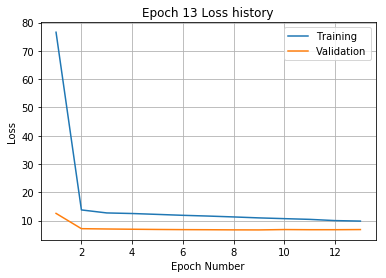

Training
Iteration 0: with minibatch training loss = 5.63 and relative error of 0.27
Iteration 20: with minibatch training loss = 13.6 and relative error of 0.42
Iteration 40: with minibatch training loss = 12.4 and relative error of 0.39
Iteration 60: with minibatch training loss = 9.94 and relative error of 0.35
Iteration 80: with minibatch training loss = 8.72 and relative error of 0.34
Iteration 100: with minibatch training loss = 8.06 and relative error of 0.32
Iteration 120: with minibatch training loss = 7.09 and relative error of 0.3
Iteration 140: with minibatch training loss = 7.41 and relative error of 0.31
Iteration 160: with minibatch training loss = 7.38 and relative error of 0.31
Iteration 180: with minibatch training loss = 11 and relative error of 0.37
Iteration 200: with minibatch training loss = 8.72 and relative error of 0.34
Iteration 220: with minibatch training loss = 7.47 and relative error of 0.3
Iteration 240: with minibatch training loss = 7.27 and relative e

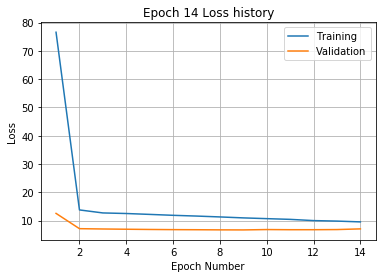

Validation error has stopped improving! Training on repetition 2 stopped!
Training
Iteration 0: with minibatch training loss = 204 and relative error of 1.6
Iteration 20: with minibatch training loss = 166 and relative error of 1.4
Iteration 40: with minibatch training loss = 123 and relative error of 1.3
Iteration 60: with minibatch training loss = 112 and relative error of 1.2
Iteration 80: with minibatch training loss = 83 and relative error of 1
Iteration 100: with minibatch training loss = 67.7 and relative error of 0.95
Iteration 120: with minibatch training loss = 62 and relative error of 0.86
Iteration 140: with minibatch training loss = 59.3 and relative error of 0.86
Iteration 160: with minibatch training loss = 38.6 and relative error of 0.7
Iteration 180: with minibatch training loss = 38.7 and relative error of 0.69
Iteration 200: with minibatch training loss = 24.2 and relative error of 0.56
Iteration 220: with minibatch training loss = 20.6 and relative error of 0.51
Ite

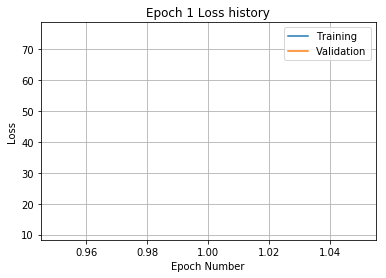

Training
Iteration 0: with minibatch training loss = 16.4 and relative error of 0.47
Iteration 20: with minibatch training loss = 13.8 and relative error of 0.43
Iteration 40: with minibatch training loss = 15.9 and relative error of 0.44
Iteration 60: with minibatch training loss = 13 and relative error of 0.4
Iteration 80: with minibatch training loss = 13.3 and relative error of 0.42
Iteration 100: with minibatch training loss = 14.2 and relative error of 0.42
Iteration 120: with minibatch training loss = 12.4 and relative error of 0.39
Iteration 140: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 160: with minibatch training loss = 12.4 and relative error of 0.4
Iteration 180: with minibatch training loss = 13 and relative error of 0.4
Iteration 200: with minibatch training loss = 14.1 and relative error of 0.43
Iteration 220: with minibatch training loss = 15.8 and relative error of 0.44
Iteration 240: with minibatch training loss = 9.27 and relative erro

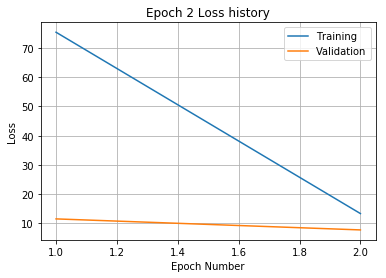

Training
Iteration 0: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 20: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 40: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 60: with minibatch training loss = 13.4 and relative error of 0.43
Iteration 80: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 100: with minibatch training loss = 11.7 and relative error of 0.41
Iteration 120: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 140: with minibatch training loss = 12.8 and relative error of 0.4
Iteration 160: with minibatch training loss = 12.2 and relative error of 0.41
Iteration 180: with minibatch training loss = 17.2 and relative error of 0.47
Iteration 200: with minibatch training loss = 10.4 and relative error of 0.37
Iteration 220: with minibatch training loss = 12 and relative error of 0.41
Iteration 240: with minibatch training loss = 13.2 and relative 

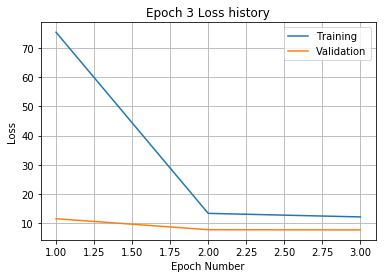

Training
Iteration 0: with minibatch training loss = 10.7 and relative error of 0.36
Iteration 20: with minibatch training loss = 13.3 and relative error of 0.43
Iteration 40: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 60: with minibatch training loss = 14.1 and relative error of 0.42
Iteration 80: with minibatch training loss = 13.1 and relative error of 0.42
Iteration 100: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 120: with minibatch training loss = 15.3 and relative error of 0.45
Iteration 140: with minibatch training loss = 10 and relative error of 0.36
Iteration 160: with minibatch training loss = 12 and relative error of 0.4
Iteration 180: with minibatch training loss = 13.9 and relative error of 0.43
Iteration 200: with minibatch training loss = 14 and relative error of 0.42
Iteration 220: with minibatch training loss = 12.1 and relative error of 0.37
Iteration 240: with minibatch training loss = 14 and relative error 

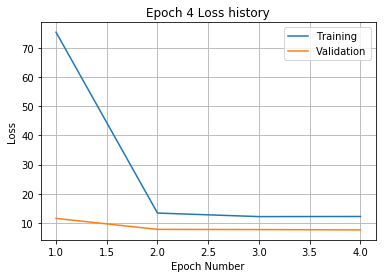

Training
Iteration 0: with minibatch training loss = 11 and relative error of 0.37
Iteration 20: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 40: with minibatch training loss = 14.3 and relative error of 0.43
Iteration 60: with minibatch training loss = 13 and relative error of 0.4
Iteration 80: with minibatch training loss = 15.4 and relative error of 0.45
Iteration 100: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 120: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 140: with minibatch training loss = 14.1 and relative error of 0.43
Iteration 160: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 180: with minibatch training loss = 12.7 and relative error of 0.4
Iteration 200: with minibatch training loss = 12 and relative error of 0.4
Iteration 220: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 240: with minibatch training loss = 11.1 and relative error o

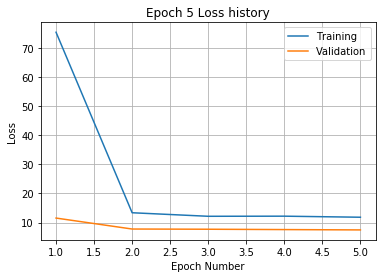

Training
Iteration 0: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 20: with minibatch training loss = 12.1 and relative error of 0.38
Iteration 40: with minibatch training loss = 10.7 and relative error of 0.36
Iteration 60: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 80: with minibatch training loss = 8.83 and relative error of 0.34
Iteration 100: with minibatch training loss = 13.5 and relative error of 0.42
Iteration 120: with minibatch training loss = 8.37 and relative error of 0.31
Iteration 140: with minibatch training loss = 11 and relative error of 0.38
Iteration 160: with minibatch training loss = 9.9 and relative error of 0.36
Iteration 180: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 200: with minibatch training loss = 10.2 and relative error of 0.34
Iteration 220: with minibatch training loss = 12.8 and relative error of 0.41
Iteration 240: with minibatch training loss = 10.5 and relative 

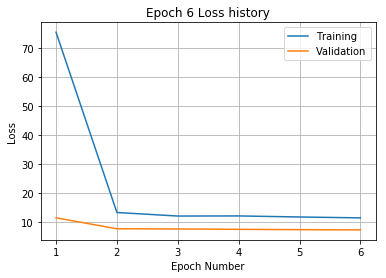

Training
Iteration 0: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 20: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 40: with minibatch training loss = 8.94 and relative error of 0.35
Iteration 60: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 80: with minibatch training loss = 13.8 and relative error of 0.43
Iteration 100: with minibatch training loss = 12.9 and relative error of 0.41
Iteration 120: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 140: with minibatch training loss = 11.3 and relative error of 0.36
Iteration 160: with minibatch training loss = 13.8 and relative error of 0.42
Iteration 180: with minibatch training loss = 9.86 and relative error of 0.35
Iteration 200: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 220: with minibatch training loss = 13 and relative error of 0.42
Iteration 240: with minibatch training loss = 14.1 and relative

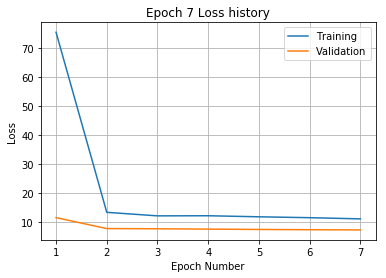

Training
Iteration 0: with minibatch training loss = 9.19 and relative error of 0.35
Iteration 20: with minibatch training loss = 13.3 and relative error of 0.41
Iteration 40: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 60: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 80: with minibatch training loss = 9.41 and relative error of 0.34
Iteration 100: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 120: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 140: with minibatch training loss = 12.5 and relative error of 0.41
Iteration 160: with minibatch training loss = 12.1 and relative error of 0.41
Iteration 180: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 200: with minibatch training loss = 8.47 and relative error of 0.33
Iteration 220: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 240: with minibatch training loss = 9.22 and relativ

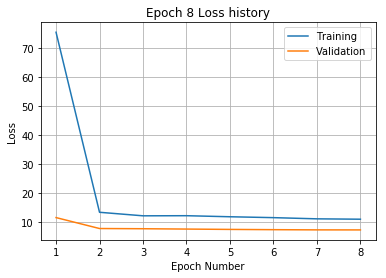

Training
Iteration 0: with minibatch training loss = 10.7 and relative error of 0.36
Iteration 20: with minibatch training loss = 9.43 and relative error of 0.35
Iteration 40: with minibatch training loss = 13.7 and relative error of 0.45
Iteration 60: with minibatch training loss = 8.2 and relative error of 0.32
Iteration 80: with minibatch training loss = 7.26 and relative error of 0.3
Iteration 100: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 120: with minibatch training loss = 11.8 and relative error of 0.38
Iteration 140: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 160: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 180: with minibatch training loss = 9.52 and relative error of 0.37
Iteration 200: with minibatch training loss = 9.15 and relative error of 0.34
Iteration 220: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 240: with minibatch training loss = 8.19 and relative

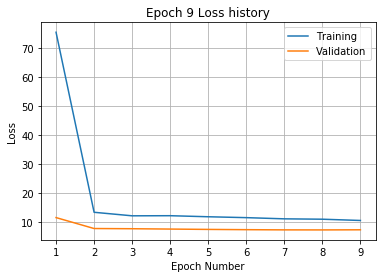

Training
Iteration 0: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 20: with minibatch training loss = 7.82 and relative error of 0.32
Iteration 40: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 60: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 80: with minibatch training loss = 7.83 and relative error of 0.31
Iteration 100: with minibatch training loss = 11 and relative error of 0.37
Iteration 120: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 140: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 160: with minibatch training loss = 9.01 and relative error of 0.34
Iteration 180: with minibatch training loss = 8.37 and relative error of 0.33
Iteration 200: with minibatch training loss = 12.6 and relative error of 0.4
Iteration 220: with minibatch training loss = 10 and relative error of 0.35
Iteration 240: with minibatch training loss = 10.7 and relative er

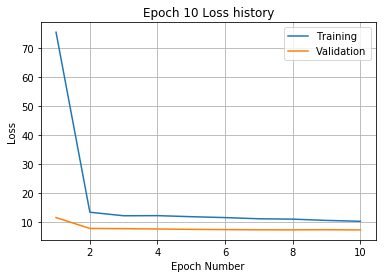

Training
Iteration 0: with minibatch training loss = 9.82 and relative error of 0.35
Iteration 20: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 40: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 60: with minibatch training loss = 9.55 and relative error of 0.35
Iteration 80: with minibatch training loss = 8.27 and relative error of 0.32
Iteration 100: with minibatch training loss = 10 and relative error of 0.36
Iteration 120: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 140: with minibatch training loss = 13.5 and relative error of 0.41
Iteration 160: with minibatch training loss = 12.9 and relative error of 0.42
Iteration 180: with minibatch training loss = 9.39 and relative error of 0.35
Iteration 200: with minibatch training loss = 10.3 and relative error of 0.37
Iteration 220: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 240: with minibatch training loss = 10.5 and relative

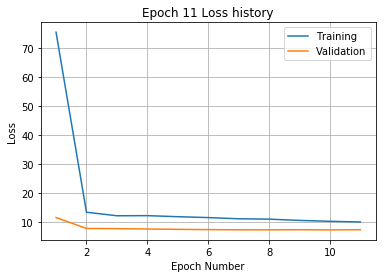

Training
Iteration 0: with minibatch training loss = 8.45 and relative error of 0.31
Iteration 20: with minibatch training loss = 9.06 and relative error of 0.34
Iteration 40: with minibatch training loss = 9.02 and relative error of 0.35
Iteration 60: with minibatch training loss = 7.67 and relative error of 0.31
Iteration 80: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 100: with minibatch training loss = 9.39 and relative error of 0.35
Iteration 120: with minibatch training loss = 12.9 and relative error of 0.41
Iteration 140: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 160: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 180: with minibatch training loss = 11.3 and relative error of 0.37
Iteration 200: with minibatch training loss = 7.72 and relative error of 0.32
Iteration 220: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 240: with minibatch training loss = 8.28 and relati

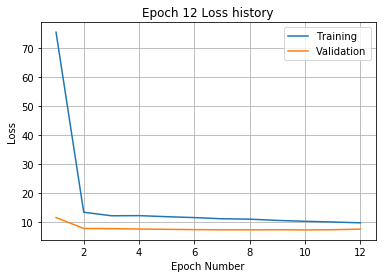

Training
Iteration 0: with minibatch training loss = 7 and relative error of 0.3
Iteration 20: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 40: with minibatch training loss = 7.28 and relative error of 0.3
Iteration 60: with minibatch training loss = 9.33 and relative error of 0.34
Iteration 80: with minibatch training loss = 8.42 and relative error of 0.33
Iteration 100: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 120: with minibatch training loss = 10.2 and relative error of 0.35
Iteration 140: with minibatch training loss = 7.32 and relative error of 0.3
Iteration 160: with minibatch training loss = 8.03 and relative error of 0.33
Iteration 180: with minibatch training loss = 7.3 and relative error of 0.31
Iteration 200: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 220: with minibatch training loss = 9.52 and relative error of 0.35
Iteration 240: with minibatch training loss = 7.04 and relative erro

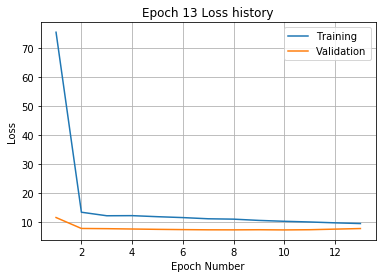

Training
Iteration 0: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 20: with minibatch training loss = 10 and relative error of 0.36
Iteration 40: with minibatch training loss = 8.83 and relative error of 0.33
Iteration 60: with minibatch training loss = 9.3 and relative error of 0.33
Iteration 80: with minibatch training loss = 6.37 and relative error of 0.3
Iteration 100: with minibatch training loss = 9.28 and relative error of 0.34
Iteration 120: with minibatch training loss = 8.86 and relative error of 0.34
Iteration 140: with minibatch training loss = 8.55 and relative error of 0.35
Iteration 160: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 180: with minibatch training loss = 8.11 and relative error of 0.32
Iteration 200: with minibatch training loss = 7.45 and relative error of 0.32
Iteration 220: with minibatch training loss = 7.23 and relative error of 0.3
Iteration 240: with minibatch training loss = 9.23 and relative er

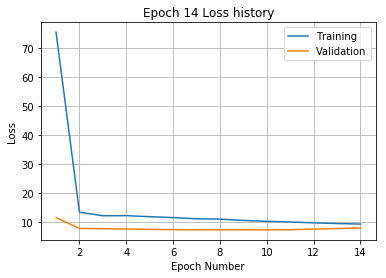

Training
Iteration 0: with minibatch training loss = 7.03 and relative error of 0.32
Iteration 20: with minibatch training loss = 8.96 and relative error of 0.33
Iteration 40: with minibatch training loss = 9.21 and relative error of 0.35
Iteration 60: with minibatch training loss = 8.8 and relative error of 0.33
Iteration 80: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 100: with minibatch training loss = 7.39 and relative error of 0.31
Iteration 120: with minibatch training loss = 6.15 and relative error of 0.27
Iteration 140: with minibatch training loss = 9.35 and relative error of 0.36
Iteration 160: with minibatch training loss = 9.83 and relative error of 0.35
Iteration 180: with minibatch training loss = 9.35 and relative error of 0.35
Iteration 200: with minibatch training loss = 6.68 and relative error of 0.3
Iteration 220: with minibatch training loss = 9.92 and relative error of 0.37
Iteration 240: with minibatch training loss = 6.74 and relative

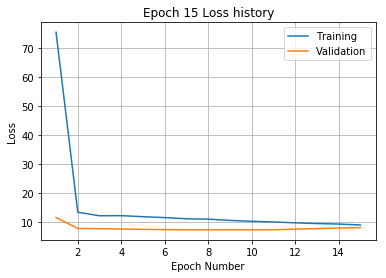

Validation error has stopped improving! Training on repetition 3 stopped!
Training
Iteration 0: with minibatch training loss = 241 and relative error of 1.8
Iteration 20: with minibatch training loss = 205 and relative error of 1.5
Iteration 40: with minibatch training loss = 157 and relative error of 1.5
Iteration 60: with minibatch training loss = 129 and relative error of 1.3
Iteration 80: with minibatch training loss = 115 and relative error of 1.2
Iteration 100: with minibatch training loss = 85.9 and relative error of 1.1
Iteration 120: with minibatch training loss = 68.8 and relative error of 0.98
Iteration 140: with minibatch training loss = 61.9 and relative error of 0.88
Iteration 160: with minibatch training loss = 45.6 and relative error of 0.77
Iteration 180: with minibatch training loss = 36 and relative error of 0.68
Iteration 200: with minibatch training loss = 25.1 and relative error of 0.57
Iteration 220: with minibatch training loss = 20 and relative error of 0.52
It

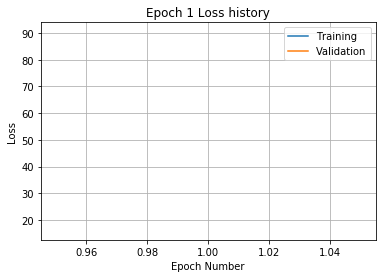

Training
Iteration 0: with minibatch training loss = 16.9 and relative error of 0.46
Iteration 20: with minibatch training loss = 19.9 and relative error of 0.52
Iteration 40: with minibatch training loss = 15 and relative error of 0.44
Iteration 60: with minibatch training loss = 12.3 and relative error of 0.38
Iteration 80: with minibatch training loss = 9.53 and relative error of 0.35
Iteration 100: with minibatch training loss = 12.2 and relative error of 0.39
Iteration 120: with minibatch training loss = 12.2 and relative error of 0.41
Iteration 140: with minibatch training loss = 15.6 and relative error of 0.44
Iteration 160: with minibatch training loss = 14.4 and relative error of 0.43
Iteration 180: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 200: with minibatch training loss = 13.2 and relative error of 0.41
Iteration 220: with minibatch training loss = 15.1 and relative error of 0.44
Iteration 240: with minibatch training loss = 10.1 and relative

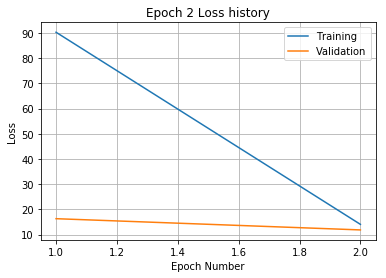

Training
Iteration 0: with minibatch training loss = 14.9 and relative error of 0.44
Iteration 20: with minibatch training loss = 16 and relative error of 0.45
Iteration 40: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 60: with minibatch training loss = 14 and relative error of 0.43
Iteration 80: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 100: with minibatch training loss = 11.9 and relative error of 0.38
Iteration 120: with minibatch training loss = 12 and relative error of 0.39
Iteration 140: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 160: with minibatch training loss = 12.6 and relative error of 0.4
Iteration 180: with minibatch training loss = 14.5 and relative error of 0.42
Iteration 200: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 220: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 240: with minibatch training loss = 10.3 and relative erro

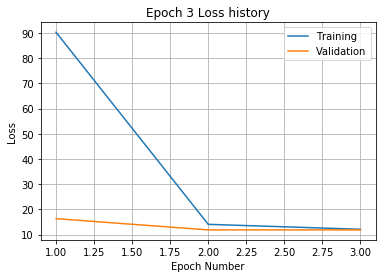

Training
Iteration 0: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 20: with minibatch training loss = 12.6 and relative error of 0.39
Iteration 40: with minibatch training loss = 12.7 and relative error of 0.4
Iteration 60: with minibatch training loss = 12.1 and relative error of 0.4
Iteration 80: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 100: with minibatch training loss = 13.3 and relative error of 0.38
Iteration 120: with minibatch training loss = 13.7 and relative error of 0.41
Iteration 140: with minibatch training loss = 11.3 and relative error of 0.37
Iteration 160: with minibatch training loss = 13.3 and relative error of 0.42
Iteration 180: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 200: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 220: with minibatch training loss = 9.1 and relative error of 0.35
Iteration 240: with minibatch training loss = 10.6 and relative er

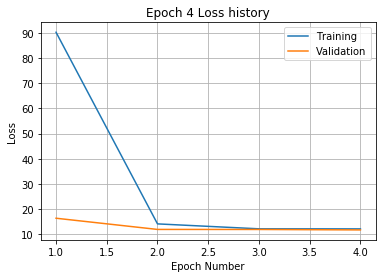

Training
Iteration 0: with minibatch training loss = 15.3 and relative error of 0.45
Iteration 20: with minibatch training loss = 9.48 and relative error of 0.35
Iteration 40: with minibatch training loss = 14.7 and relative error of 0.44
Iteration 60: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 80: with minibatch training loss = 12.6 and relative error of 0.4
Iteration 100: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 120: with minibatch training loss = 9.67 and relative error of 0.35
Iteration 140: with minibatch training loss = 9.22 and relative error of 0.34
Iteration 160: with minibatch training loss = 15.5 and relative error of 0.43
Iteration 180: with minibatch training loss = 13.5 and relative error of 0.44
Iteration 200: with minibatch training loss = 9.57 and relative error of 0.36
Iteration 220: with minibatch training loss = 14.5 and relative error of 0.44
Iteration 240: with minibatch training loss = 12 and relative 

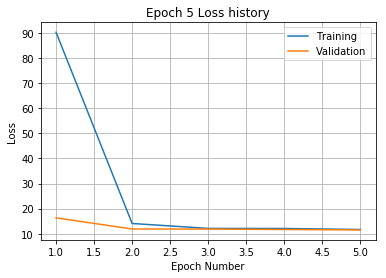

Training
Iteration 0: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 20: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 40: with minibatch training loss = 12.5 and relative error of 0.41
Iteration 60: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 80: with minibatch training loss = 8.49 and relative error of 0.31
Iteration 100: with minibatch training loss = 11 and relative error of 0.37
Iteration 120: with minibatch training loss = 11.2 and relative error of 0.37
Iteration 140: with minibatch training loss = 14.2 and relative error of 0.42
Iteration 160: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 180: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 200: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 220: with minibatch training loss = 11.5 and relative error of 0.37
Iteration 240: with minibatch training loss = 10.8 and relative e

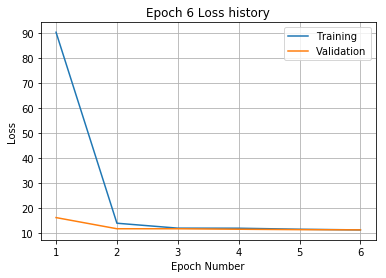

Training
Iteration 0: with minibatch training loss = 9.83 and relative error of 0.34
Iteration 20: with minibatch training loss = 11.8 and relative error of 0.38
Iteration 40: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 60: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 80: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 100: with minibatch training loss = 12.4 and relative error of 0.4
Iteration 120: with minibatch training loss = 9.23 and relative error of 0.34
Iteration 140: with minibatch training loss = 13.8 and relative error of 0.42
Iteration 160: with minibatch training loss = 10 and relative error of 0.35
Iteration 180: with minibatch training loss = 12.5 and relative error of 0.39
Iteration 200: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 220: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 240: with minibatch training loss = 10.6 and relative e

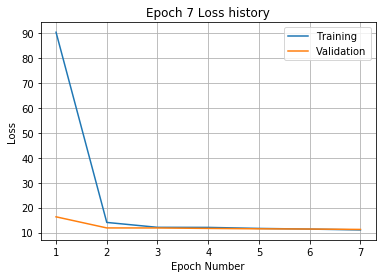

Training
Iteration 0: with minibatch training loss = 11 and relative error of 0.38
Iteration 20: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 40: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 60: with minibatch training loss = 9.38 and relative error of 0.34
Iteration 80: with minibatch training loss = 10.9 and relative error of 0.39
Iteration 100: with minibatch training loss = 9.31 and relative error of 0.33
Iteration 120: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 140: with minibatch training loss = 12.5 and relative error of 0.38
Iteration 160: with minibatch training loss = 9.71 and relative error of 0.34
Iteration 180: with minibatch training loss = 11.2 and relative error of 0.37
Iteration 200: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 220: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 240: with minibatch training loss = 10.6 and relative 

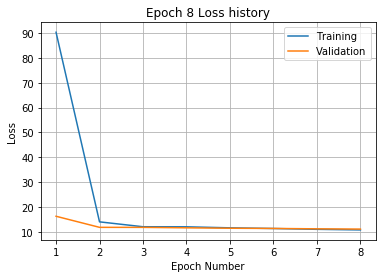

Training
Iteration 0: with minibatch training loss = 11 and relative error of 0.38
Iteration 20: with minibatch training loss = 10 and relative error of 0.36
Iteration 40: with minibatch training loss = 9.77 and relative error of 0.36
Iteration 60: with minibatch training loss = 9.5 and relative error of 0.35
Iteration 80: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 100: with minibatch training loss = 7.84 and relative error of 0.33
Iteration 120: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 140: with minibatch training loss = 8.85 and relative error of 0.35
Iteration 160: with minibatch training loss = 9.43 and relative error of 0.36
Iteration 180: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 200: with minibatch training loss = 12.9 and relative error of 0.41
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 240: with minibatch training loss = 11.1 and relative er

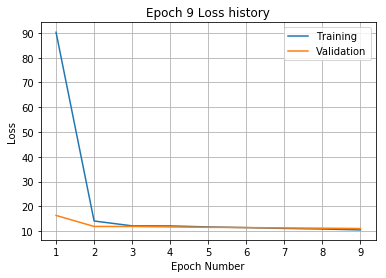

Training
Iteration 0: with minibatch training loss = 9.93 and relative error of 0.37
Iteration 20: with minibatch training loss = 8.67 and relative error of 0.33
Iteration 40: with minibatch training loss = 11.7 and relative error of 0.4
Iteration 60: with minibatch training loss = 11.1 and relative error of 0.39
Iteration 80: with minibatch training loss = 9.61 and relative error of 0.35
Iteration 100: with minibatch training loss = 9.48 and relative error of 0.35
Iteration 120: with minibatch training loss = 12.6 and relative error of 0.42
Iteration 140: with minibatch training loss = 11.7 and relative error of 0.4
Iteration 160: with minibatch training loss = 9.83 and relative error of 0.35
Iteration 180: with minibatch training loss = 12 and relative error of 0.39
Iteration 200: with minibatch training loss = 9.36 and relative error of 0.35
Iteration 220: with minibatch training loss = 9.87 and relative error of 0.34
Iteration 240: with minibatch training loss = 11.3 and relative e

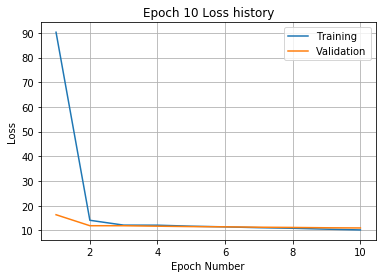

Training
Iteration 0: with minibatch training loss = 12.8 and relative error of 0.42
Iteration 20: with minibatch training loss = 8.93 and relative error of 0.33
Iteration 40: with minibatch training loss = 11.6 and relative error of 0.4
Iteration 60: with minibatch training loss = 7.12 and relative error of 0.3
Iteration 80: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 100: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 120: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 140: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 160: with minibatch training loss = 12 and relative error of 0.39
Iteration 180: with minibatch training loss = 9.35 and relative error of 0.35
Iteration 200: with minibatch training loss = 6.76 and relative error of 0.29
Iteration 220: with minibatch training loss = 10.8 and relative error of 0.36
Iteration 240: with minibatch training loss = 10.4 and relative e

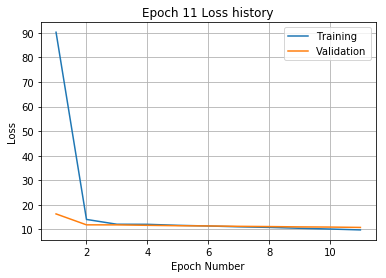

Training
Iteration 0: with minibatch training loss = 8.36 and relative error of 0.32
Iteration 20: with minibatch training loss = 7.54 and relative error of 0.31
Iteration 40: with minibatch training loss = 7.64 and relative error of 0.31
Iteration 60: with minibatch training loss = 9.14 and relative error of 0.34
Iteration 80: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 100: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 120: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 140: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 160: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 180: with minibatch training loss = 7.36 and relative error of 0.31
Iteration 200: with minibatch training loss = 10.3 and relative error of 0.37
Iteration 220: with minibatch training loss = 8.12 and relative error of 0.32
Iteration 240: with minibatch training loss = 8.62 and relati

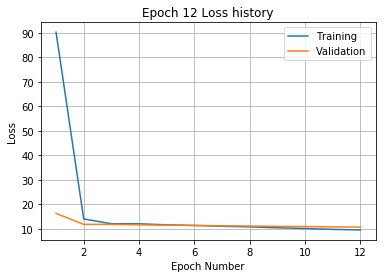

Training
Iteration 0: with minibatch training loss = 8.7 and relative error of 0.34
Iteration 20: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 40: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 60: with minibatch training loss = 7.08 and relative error of 0.3
Iteration 80: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 100: with minibatch training loss = 13.3 and relative error of 0.42
Iteration 120: with minibatch training loss = 9.42 and relative error of 0.34
Iteration 140: with minibatch training loss = 9.94 and relative error of 0.36
Iteration 160: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 180: with minibatch training loss = 8.87 and relative error of 0.32
Iteration 200: with minibatch training loss = 8.98 and relative error of 0.33
Iteration 220: with minibatch training loss = 9.04 and relative error of 0.33
Iteration 240: with minibatch training loss = 10.7 and relative

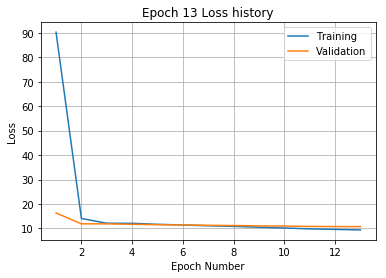

Training
Iteration 0: with minibatch training loss = 7.91 and relative error of 0.31
Iteration 20: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 40: with minibatch training loss = 9.39 and relative error of 0.34
Iteration 60: with minibatch training loss = 8.05 and relative error of 0.32
Iteration 80: with minibatch training loss = 9.19 and relative error of 0.34
Iteration 100: with minibatch training loss = 8.3 and relative error of 0.32
Iteration 120: with minibatch training loss = 8.37 and relative error of 0.34
Iteration 140: with minibatch training loss = 9.56 and relative error of 0.36
Iteration 160: with minibatch training loss = 9.52 and relative error of 0.35
Iteration 180: with minibatch training loss = 9.7 and relative error of 0.35
Iteration 200: with minibatch training loss = 7.59 and relative error of 0.32
Iteration 220: with minibatch training loss = 9.28 and relative error of 0.35
Iteration 240: with minibatch training loss = 11.3 and relative

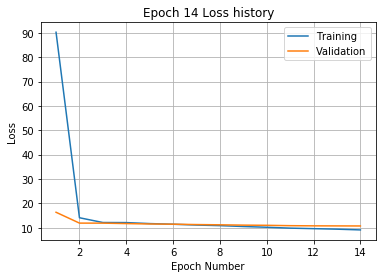

Training
Iteration 0: with minibatch training loss = 7.39 and relative error of 0.31
Iteration 20: with minibatch training loss = 7.37 and relative error of 0.29
Iteration 40: with minibatch training loss = 7.97 and relative error of 0.32
Iteration 60: with minibatch training loss = 6.85 and relative error of 0.29
Iteration 80: with minibatch training loss = 7.42 and relative error of 0.31
Iteration 100: with minibatch training loss = 8.51 and relative error of 0.33
Iteration 120: with minibatch training loss = 8.35 and relative error of 0.34
Iteration 140: with minibatch training loss = 6.8 and relative error of 0.31
Iteration 160: with minibatch training loss = 9.49 and relative error of 0.35
Iteration 180: with minibatch training loss = 10.4 and relative error of 0.37
Iteration 200: with minibatch training loss = 6.13 and relative error of 0.28
Iteration 220: with minibatch training loss = 10.4 and relative error of 0.38
Iteration 240: with minibatch training loss = 7.99 and relativ

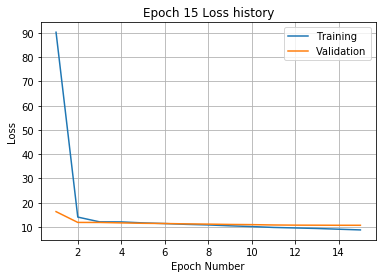

Training
Iteration 0: with minibatch training loss = 9.68 and relative error of 0.36
Iteration 20: with minibatch training loss = 8.37 and relative error of 0.33
Iteration 40: with minibatch training loss = 7.48 and relative error of 0.3
Iteration 60: with minibatch training loss = 7.51 and relative error of 0.31
Iteration 80: with minibatch training loss = 10.2 and relative error of 0.35
Iteration 100: with minibatch training loss = 10.2 and relative error of 0.35
Iteration 120: with minibatch training loss = 7.67 and relative error of 0.31
Iteration 140: with minibatch training loss = 8.44 and relative error of 0.34
Iteration 160: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 180: with minibatch training loss = 9.64 and relative error of 0.35
Iteration 200: with minibatch training loss = 7.79 and relative error of 0.31
Iteration 220: with minibatch training loss = 7.17 and relative error of 0.3
Iteration 240: with minibatch training loss = 11.6 and relative

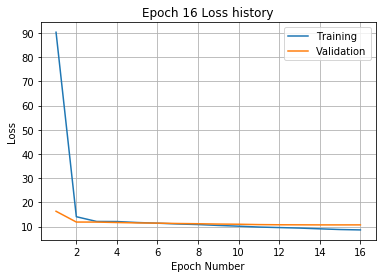

Training
Iteration 0: with minibatch training loss = 7.64 and relative error of 0.32
Iteration 20: with minibatch training loss = 7.3 and relative error of 0.29
Iteration 40: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 60: with minibatch training loss = 7.56 and relative error of 0.3
Iteration 80: with minibatch training loss = 9.06 and relative error of 0.34
Iteration 100: with minibatch training loss = 8.75 and relative error of 0.34
Iteration 120: with minibatch training loss = 7.26 and relative error of 0.3
Iteration 140: with minibatch training loss = 8.84 and relative error of 0.34
Iteration 160: with minibatch training loss = 6.87 and relative error of 0.3
Iteration 180: with minibatch training loss = 8.07 and relative error of 0.31
Iteration 200: with minibatch training loss = 8.19 and relative error of 0.33
Iteration 220: with minibatch training loss = 7.04 and relative error of 0.3
Iteration 240: with minibatch training loss = 6.97 and relative er

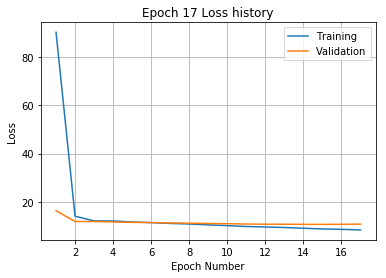

Training
Iteration 0: with minibatch training loss = 8.84 and relative error of 0.34
Iteration 20: with minibatch training loss = 6.26 and relative error of 0.28
Iteration 40: with minibatch training loss = 7.21 and relative error of 0.29
Iteration 60: with minibatch training loss = 8.69 and relative error of 0.33
Iteration 80: with minibatch training loss = 8.05 and relative error of 0.31
Iteration 100: with minibatch training loss = 7.28 and relative error of 0.31
Iteration 120: with minibatch training loss = 5.22 and relative error of 0.25
Iteration 140: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 160: with minibatch training loss = 7.98 and relative error of 0.33
Iteration 180: with minibatch training loss = 7.72 and relative error of 0.33
Iteration 200: with minibatch training loss = 8.29 and relative error of 0.33
Iteration 220: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 240: with minibatch training loss = 8.12 and relati

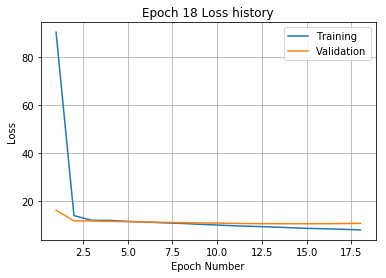

Training
Iteration 0: with minibatch training loss = 7.31 and relative error of 0.3
Iteration 20: with minibatch training loss = 13.3 and relative error of 0.4
Iteration 40: with minibatch training loss = 5.12 and relative error of 0.26
Iteration 60: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 80: with minibatch training loss = 7.79 and relative error of 0.33
Iteration 100: with minibatch training loss = 8.2 and relative error of 0.33
Iteration 120: with minibatch training loss = 6.71 and relative error of 0.3
Iteration 140: with minibatch training loss = 5.97 and relative error of 0.28
Iteration 160: with minibatch training loss = 7.01 and relative error of 0.3
Iteration 180: with minibatch training loss = 7.32 and relative error of 0.31
Iteration 200: with minibatch training loss = 7.49 and relative error of 0.32
Iteration 220: with minibatch training loss = 7.15 and relative error of 0.31
Iteration 240: with minibatch training loss = 8.53 and relative er

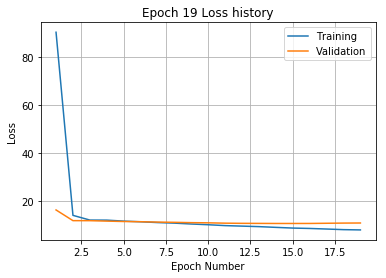

Training
Iteration 0: with minibatch training loss = 5.99 and relative error of 0.27
Iteration 20: with minibatch training loss = 6.71 and relative error of 0.29
Iteration 40: with minibatch training loss = 6.83 and relative error of 0.3
Iteration 60: with minibatch training loss = 8.92 and relative error of 0.33
Iteration 80: with minibatch training loss = 5.69 and relative error of 0.28
Iteration 100: with minibatch training loss = 8.86 and relative error of 0.32
Iteration 120: with minibatch training loss = 7.22 and relative error of 0.31
Iteration 140: with minibatch training loss = 7.66 and relative error of 0.32
Iteration 160: with minibatch training loss = 7.58 and relative error of 0.31
Iteration 180: with minibatch training loss = 5.7 and relative error of 0.27
Iteration 200: with minibatch training loss = 7.76 and relative error of 0.32
Iteration 220: with minibatch training loss = 5.27 and relative error of 0.26
Iteration 240: with minibatch training loss = 8.92 and relative

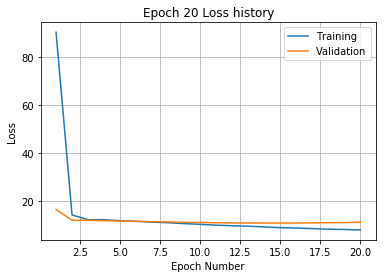

Validation error has stopped improving! Training on repetition 4 stopped!
Training
Iteration 0: with minibatch training loss = 143 and relative error of 1.4
Iteration 20: with minibatch training loss = 137 and relative error of 1.3
Iteration 40: with minibatch training loss = 99.1 and relative error of 1.1
Iteration 60: with minibatch training loss = 80.1 and relative error of 1
Iteration 80: with minibatch training loss = 59.2 and relative error of 0.86
Iteration 100: with minibatch training loss = 51.9 and relative error of 0.8
Iteration 120: with minibatch training loss = 36.2 and relative error of 0.73
Iteration 140: with minibatch training loss = 28.7 and relative error of 0.61
Iteration 160: with minibatch training loss = 24.5 and relative error of 0.53
Iteration 180: with minibatch training loss = 18.9 and relative error of 0.48
Iteration 200: with minibatch training loss = 15.6 and relative error of 0.45
Iteration 220: with minibatch training loss = 17.4 and relative error of 0

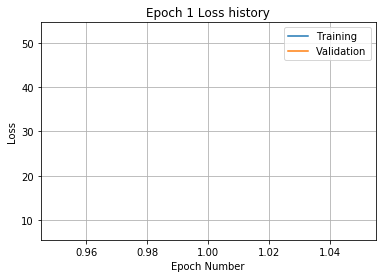

Training
Iteration 0: with minibatch training loss = 8.07 and relative error of 0.33
Iteration 20: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 40: with minibatch training loss = 9.92 and relative error of 0.36
Iteration 60: with minibatch training loss = 14.2 and relative error of 0.41
Iteration 80: with minibatch training loss = 9.22 and relative error of 0.34
Iteration 100: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 120: with minibatch training loss = 11.2 and relative error of 0.37
Iteration 140: with minibatch training loss = 10.8 and relative error of 0.36
Iteration 160: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 180: with minibatch training loss = 11.5 and relative error of 0.37
Iteration 200: with minibatch training loss = 14.7 and relative error of 0.41
Iteration 220: with minibatch training loss = 17.1 and relative error of 0.46
Iteration 240: with minibatch training loss = 17.3 and relati

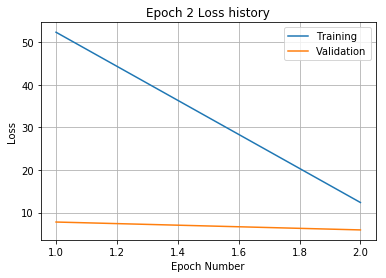

Training
Iteration 0: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 20: with minibatch training loss = 12.4 and relative error of 0.4
Iteration 40: with minibatch training loss = 17.5 and relative error of 0.46
Iteration 60: with minibatch training loss = 8.97 and relative error of 0.33
Iteration 80: with minibatch training loss = 9.68 and relative error of 0.36
Iteration 100: with minibatch training loss = 14.1 and relative error of 0.44
Iteration 120: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 140: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 160: with minibatch training loss = 9.51 and relative error of 0.35
Iteration 180: with minibatch training loss = 14 and relative error of 0.43
Iteration 200: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 220: with minibatch training loss = 12.9 and relative error of 0.39
Iteration 240: with minibatch training loss = 11.8 and relative 

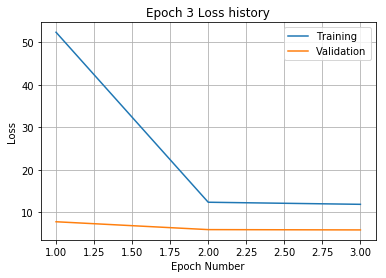

Training
Iteration 0: with minibatch training loss = 8.71 and relative error of 0.32
Iteration 20: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 40: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 60: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 80: with minibatch training loss = 15.9 and relative error of 0.44
Iteration 100: with minibatch training loss = 13.1 and relative error of 0.4
Iteration 120: with minibatch training loss = 9 and relative error of 0.33
Iteration 140: with minibatch training loss = 9.96 and relative error of 0.36
Iteration 160: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 180: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 200: with minibatch training loss = 12.4 and relative error of 0.4
Iteration 220: with minibatch training loss = 12.1 and relative error of 0.4
Iteration 240: with minibatch training loss = 9.69 and relative err

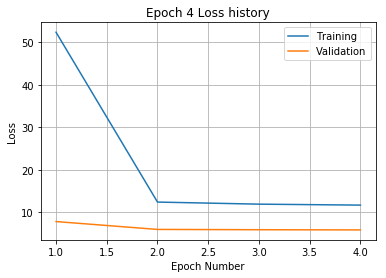

Training
Iteration 0: with minibatch training loss = 11.8 and relative error of 0.38
Iteration 20: with minibatch training loss = 12 and relative error of 0.39
Iteration 40: with minibatch training loss = 11.5 and relative error of 0.36
Iteration 60: with minibatch training loss = 9.94 and relative error of 0.36
Iteration 80: with minibatch training loss = 14 and relative error of 0.44
Iteration 100: with minibatch training loss = 9.15 and relative error of 0.35
Iteration 120: with minibatch training loss = 8.49 and relative error of 0.33
Iteration 140: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 160: with minibatch training loss = 9.22 and relative error of 0.34
Iteration 180: with minibatch training loss = 9.74 and relative error of 0.36
Iteration 200: with minibatch training loss = 13.2 and relative error of 0.4
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 240: with minibatch training loss = 9.85 and relative er

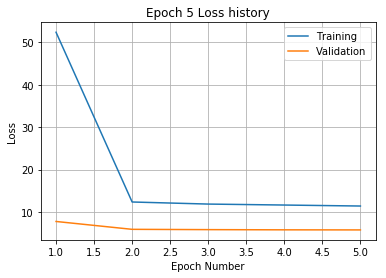

Training
Iteration 0: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 20: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 40: with minibatch training loss = 14.3 and relative error of 0.44
Iteration 60: with minibatch training loss = 11.9 and relative error of 0.38
Iteration 80: with minibatch training loss = 8.15 and relative error of 0.32
Iteration 100: with minibatch training loss = 13 and relative error of 0.42
Iteration 120: with minibatch training loss = 9.88 and relative error of 0.35
Iteration 140: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 160: with minibatch training loss = 13 and relative error of 0.42
Iteration 180: with minibatch training loss = 9.64 and relative error of 0.35
Iteration 200: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 220: with minibatch training loss = 13.1 and relative error of 0.38
Iteration 240: with minibatch training loss = 11.9 and relative e

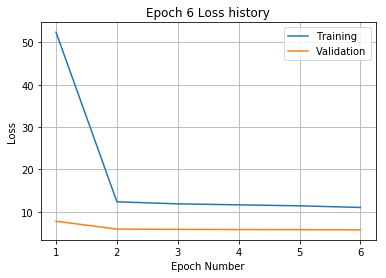

Training
Iteration 0: with minibatch training loss = 11.9 and relative error of 0.41
Iteration 20: with minibatch training loss = 14.8 and relative error of 0.44
Iteration 40: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 60: with minibatch training loss = 13.9 and relative error of 0.42
Iteration 80: with minibatch training loss = 13 and relative error of 0.39
Iteration 100: with minibatch training loss = 11.3 and relative error of 0.37
Iteration 120: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 140: with minibatch training loss = 12.8 and relative error of 0.4
Iteration 160: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 180: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 200: with minibatch training loss = 7.37 and relative error of 0.31
Iteration 220: with minibatch training loss = 10.7 and relative error of 0.35
Iteration 240: with minibatch training loss = 9.46 and relative e

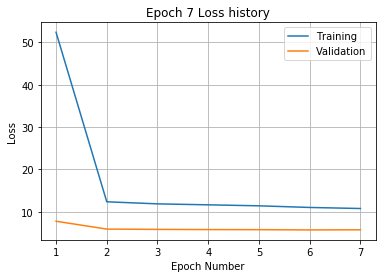

Training
Iteration 0: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 20: with minibatch training loss = 9.83 and relative error of 0.35
Iteration 40: with minibatch training loss = 10.4 and relative error of 0.35
Iteration 60: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 80: with minibatch training loss = 9.9 and relative error of 0.36
Iteration 100: with minibatch training loss = 8.47 and relative error of 0.32
Iteration 120: with minibatch training loss = 11 and relative error of 0.38
Iteration 140: with minibatch training loss = 9.89 and relative error of 0.35
Iteration 160: with minibatch training loss = 7.86 and relative error of 0.31
Iteration 180: with minibatch training loss = 7.73 and relative error of 0.31
Iteration 200: with minibatch training loss = 10 and relative error of 0.36
Iteration 220: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 240: with minibatch training loss = 8.19 and relative err

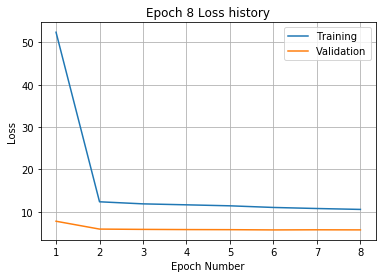

Training
Iteration 0: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 20: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 40: with minibatch training loss = 9.81 and relative error of 0.36
Iteration 60: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 80: with minibatch training loss = 9.56 and relative error of 0.36
Iteration 100: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 120: with minibatch training loss = 10 and relative error of 0.35
Iteration 140: with minibatch training loss = 10.6 and relative error of 0.39
Iteration 160: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 180: with minibatch training loss = 8.72 and relative error of 0.34
Iteration 200: with minibatch training loss = 9.3 and relative error of 0.34
Iteration 220: with minibatch training loss = 9.67 and relative error of 0.35
Iteration 240: with minibatch training loss = 8.15 and relative 

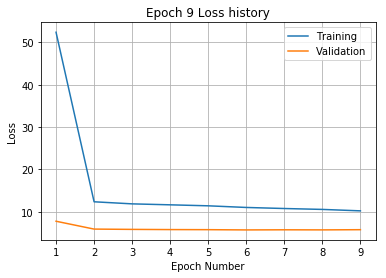

Training
Iteration 0: with minibatch training loss = 10.2 and relative error of 0.35
Iteration 20: with minibatch training loss = 8.25 and relative error of 0.33
Iteration 40: with minibatch training loss = 9.55 and relative error of 0.35
Iteration 60: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 80: with minibatch training loss = 8.81 and relative error of 0.34
Iteration 100: with minibatch training loss = 11 and relative error of 0.37
Iteration 120: with minibatch training loss = 9.08 and relative error of 0.33
Iteration 140: with minibatch training loss = 8.55 and relative error of 0.33
Iteration 160: with minibatch training loss = 11.8 and relative error of 0.38
Iteration 180: with minibatch training loss = 7.66 and relative error of 0.3
Iteration 200: with minibatch training loss = 9.4 and relative error of 0.35
Iteration 220: with minibatch training loss = 8.48 and relative error of 0.33
Iteration 240: with minibatch training loss = 10.6 and relative e

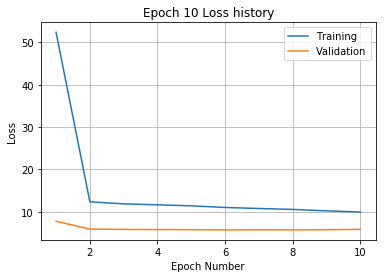

Training
Iteration 0: with minibatch training loss = 10.3 and relative error of 0.37
Iteration 20: with minibatch training loss = 7.88 and relative error of 0.31
Iteration 40: with minibatch training loss = 13.3 and relative error of 0.42
Iteration 60: with minibatch training loss = 9.78 and relative error of 0.35
Iteration 80: with minibatch training loss = 9.94 and relative error of 0.35
Iteration 100: with minibatch training loss = 9.14 and relative error of 0.35
Iteration 120: with minibatch training loss = 10.5 and relative error of 0.35
Iteration 140: with minibatch training loss = 9.4 and relative error of 0.34
Iteration 160: with minibatch training loss = 7.44 and relative error of 0.31
Iteration 180: with minibatch training loss = 9.03 and relative error of 0.36
Iteration 200: with minibatch training loss = 8.98 and relative error of 0.35
Iteration 220: with minibatch training loss = 11.1 and relative error of 0.36
Iteration 240: with minibatch training loss = 7.4 and relative

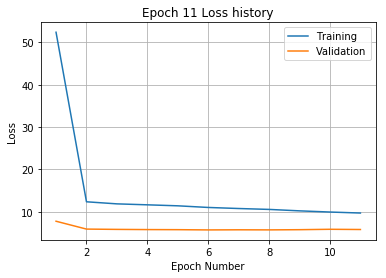

Validation error has stopped improving! Training on repetition 5 stopped!
Training
Iteration 0: with minibatch training loss = 195 and relative error of 1.6
Iteration 20: with minibatch training loss = 190 and relative error of 1.6
Iteration 40: with minibatch training loss = 151 and relative error of 1.4
Iteration 60: with minibatch training loss = 117 and relative error of 1.2
Iteration 80: with minibatch training loss = 86.2 and relative error of 1.1
Iteration 100: with minibatch training loss = 74.4 and relative error of 0.97
Iteration 120: with minibatch training loss = 57.2 and relative error of 0.86
Iteration 140: with minibatch training loss = 40.8 and relative error of 0.71
Iteration 160: with minibatch training loss = 40.6 and relative error of 0.73
Iteration 180: with minibatch training loss = 28.1 and relative error of 0.61
Iteration 200: with minibatch training loss = 28.1 and relative error of 0.61
Iteration 220: with minibatch training loss = 18.4 and relative error of 0

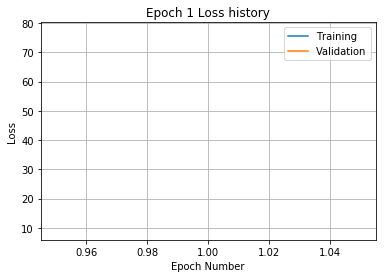

Training
Iteration 0: with minibatch training loss = 16.6 and relative error of 0.47
Iteration 20: with minibatch training loss = 16.7 and relative error of 0.47
Iteration 40: with minibatch training loss = 14.5 and relative error of 0.43
Iteration 60: with minibatch training loss = 18.2 and relative error of 0.5
Iteration 80: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 100: with minibatch training loss = 13.9 and relative error of 0.42
Iteration 120: with minibatch training loss = 14.4 and relative error of 0.45
Iteration 140: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 160: with minibatch training loss = 16.9 and relative error of 0.48
Iteration 180: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 200: with minibatch training loss = 13.9 and relative error of 0.42
Iteration 220: with minibatch training loss = 12 and relative error of 0.39
Iteration 240: with minibatch training loss = 12.1 and relative e

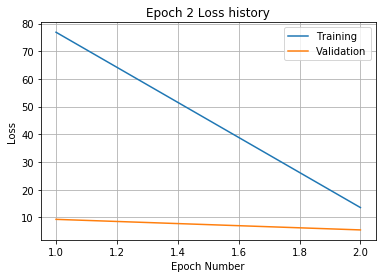

Training
Iteration 0: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 20: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 40: with minibatch training loss = 11.7 and relative error of 0.4
Iteration 60: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 80: with minibatch training loss = 13.8 and relative error of 0.42
Iteration 100: with minibatch training loss = 14.2 and relative error of 0.42
Iteration 120: with minibatch training loss = 15.1 and relative error of 0.43
Iteration 140: with minibatch training loss = 13.8 and relative error of 0.41
Iteration 160: with minibatch training loss = 13.5 and relative error of 0.42
Iteration 180: with minibatch training loss = 14.5 and relative error of 0.42
Iteration 200: with minibatch training loss = 14.3 and relative error of 0.44
Iteration 220: with minibatch training loss = 12.9 and relative error of 0.4
Iteration 240: with minibatch training loss = 10.6 and relative

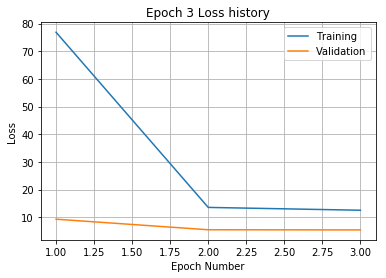

Training
Iteration 0: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 20: with minibatch training loss = 14.9 and relative error of 0.44
Iteration 40: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 60: with minibatch training loss = 17 and relative error of 0.46
Iteration 80: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 100: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 120: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 140: with minibatch training loss = 14.1 and relative error of 0.43
Iteration 160: with minibatch training loss = 15.1 and relative error of 0.44
Iteration 180: with minibatch training loss = 9.75 and relative error of 0.36
Iteration 200: with minibatch training loss = 13.2 and relative error of 0.39
Iteration 220: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 240: with minibatch training loss = 13.5 and relative

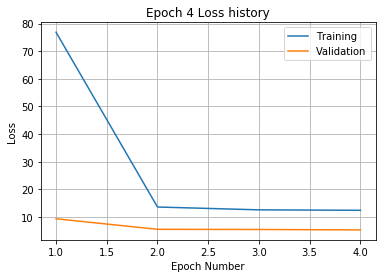

Training
Iteration 0: with minibatch training loss = 13.4 and relative error of 0.42
Iteration 20: with minibatch training loss = 16 and relative error of 0.47
Iteration 40: with minibatch training loss = 9.55 and relative error of 0.35
Iteration 60: with minibatch training loss = 14.3 and relative error of 0.44
Iteration 80: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 100: with minibatch training loss = 14.2 and relative error of 0.43
Iteration 120: with minibatch training loss = 12.2 and relative error of 0.42
Iteration 140: with minibatch training loss = 9.99 and relative error of 0.37
Iteration 160: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 180: with minibatch training loss = 12.1 and relative error of 0.41
Iteration 200: with minibatch training loss = 9.21 and relative error of 0.34
Iteration 220: with minibatch training loss = 16 and relative error of 0.46
Iteration 240: with minibatch training loss = 11.1 and relative e

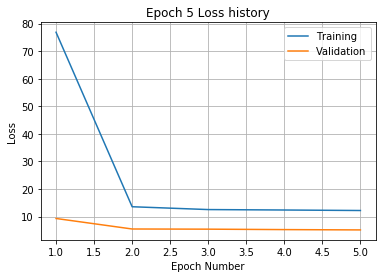

Training
Iteration 0: with minibatch training loss = 9.03 and relative error of 0.34
Iteration 20: with minibatch training loss = 13 and relative error of 0.42
Iteration 40: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 60: with minibatch training loss = 12.4 and relative error of 0.39
Iteration 80: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 100: with minibatch training loss = 12.5 and relative error of 0.41
Iteration 120: with minibatch training loss = 11.7 and relative error of 0.4
Iteration 140: with minibatch training loss = 15.2 and relative error of 0.43
Iteration 160: with minibatch training loss = 8.3 and relative error of 0.33
Iteration 180: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 200: with minibatch training loss = 9.09 and relative error of 0.34
Iteration 220: with minibatch training loss = 15.6 and relative error of 0.48
Iteration 240: with minibatch training loss = 10.8 and relative er

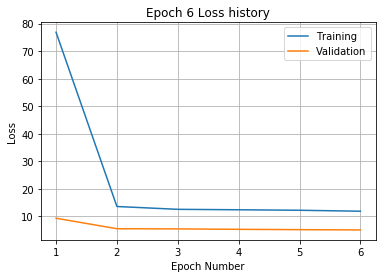

Training
Iteration 0: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 20: with minibatch training loss = 12.6 and relative error of 0.43
Iteration 40: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 60: with minibatch training loss = 12.6 and relative error of 0.4
Iteration 80: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 100: with minibatch training loss = 10.2 and relative error of 0.38
Iteration 120: with minibatch training loss = 14.7 and relative error of 0.43
Iteration 140: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 160: with minibatch training loss = 12.5 and relative error of 0.41
Iteration 180: with minibatch training loss = 9.94 and relative error of 0.36
Iteration 200: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 220: with minibatch training loss = 9.51 and relative error of 0.36
Iteration 240: with minibatch training loss = 8.23 and relativ

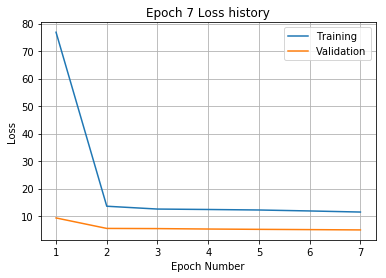

Training
Iteration 0: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 20: with minibatch training loss = 9.37 and relative error of 0.35
Iteration 40: with minibatch training loss = 16.2 and relative error of 0.46
Iteration 60: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 80: with minibatch training loss = 13.8 and relative error of 0.43
Iteration 100: with minibatch training loss = 13.7 and relative error of 0.42
Iteration 120: with minibatch training loss = 14.9 and relative error of 0.42
Iteration 140: with minibatch training loss = 9.93 and relative error of 0.35
Iteration 160: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 180: with minibatch training loss = 11.6 and relative error of 0.4
Iteration 200: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 220: with minibatch training loss = 14.5 and relative error of 0.42
Iteration 240: with minibatch training loss = 10.7 and relativ

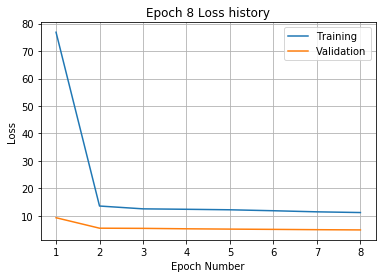

Training
Iteration 0: with minibatch training loss = 13 and relative error of 0.41
Iteration 20: with minibatch training loss = 13.8 and relative error of 0.41
Iteration 40: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 60: with minibatch training loss = 8.9 and relative error of 0.33
Iteration 80: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 100: with minibatch training loss = 14.5 and relative error of 0.43
Iteration 120: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 140: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 160: with minibatch training loss = 9.74 and relative error of 0.36
Iteration 180: with minibatch training loss = 12.6 and relative error of 0.38
Iteration 200: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 220: with minibatch training loss = 7.24 and relative error of 0.31
Iteration 240: with minibatch training loss = 10.8 and relative e

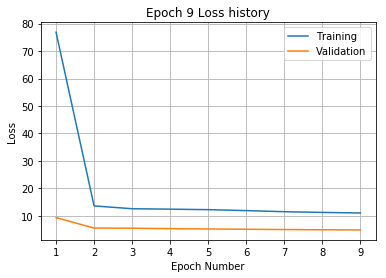

Training
Iteration 0: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 20: with minibatch training loss = 9.68 and relative error of 0.36
Iteration 40: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 60: with minibatch training loss = 9.54 and relative error of 0.36
Iteration 80: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 100: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 120: with minibatch training loss = 9.62 and relative error of 0.36
Iteration 140: with minibatch training loss = 9.91 and relative error of 0.36
Iteration 160: with minibatch training loss = 9.26 and relative error of 0.34
Iteration 180: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 200: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 220: with minibatch training loss = 12.8 and relative error of 0.41
Iteration 240: with minibatch training loss = 13.2 and relati

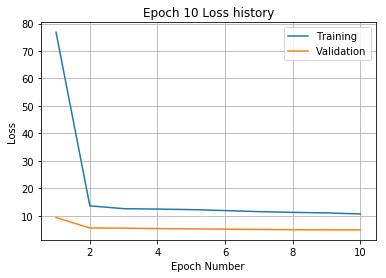

Training
Iteration 0: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 20: with minibatch training loss = 12.9 and relative error of 0.41
Iteration 40: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 60: with minibatch training loss = 11 and relative error of 0.37
Iteration 80: with minibatch training loss = 11.9 and relative error of 0.42
Iteration 100: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 120: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 140: with minibatch training loss = 11.5 and relative error of 0.37
Iteration 160: with minibatch training loss = 8.46 and relative error of 0.33
Iteration 180: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 200: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 220: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 240: with minibatch training loss = 9.71 and relative

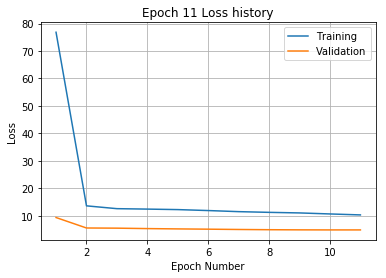

Training
Iteration 0: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 20: with minibatch training loss = 7.5 and relative error of 0.32
Iteration 40: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 60: with minibatch training loss = 12.6 and relative error of 0.39
Iteration 80: with minibatch training loss = 8.91 and relative error of 0.33
Iteration 100: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 120: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 140: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 160: with minibatch training loss = 8.56 and relative error of 0.32
Iteration 180: with minibatch training loss = 8.98 and relative error of 0.34
Iteration 200: with minibatch training loss = 10.2 and relative error of 0.39
Iteration 220: with minibatch training loss = 10.3 and relative error of 0.35
Iteration 240: with minibatch training loss = 11.9 and relativ

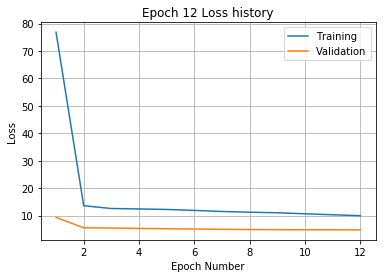

Training
Iteration 0: with minibatch training loss = 8.79 and relative error of 0.32
Iteration 20: with minibatch training loss = 8.51 and relative error of 0.32
Iteration 40: with minibatch training loss = 7.49 and relative error of 0.32
Iteration 60: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 80: with minibatch training loss = 8.25 and relative error of 0.32
Iteration 100: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 120: with minibatch training loss = 9.23 and relative error of 0.35
Iteration 140: with minibatch training loss = 9.19 and relative error of 0.35
Iteration 160: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 180: with minibatch training loss = 9.57 and relative error of 0.36
Iteration 200: with minibatch training loss = 9.58 and relative error of 0.35
Iteration 220: with minibatch training loss = 8.79 and relative error of 0.33
Iteration 240: with minibatch training loss = 7.51 and relati

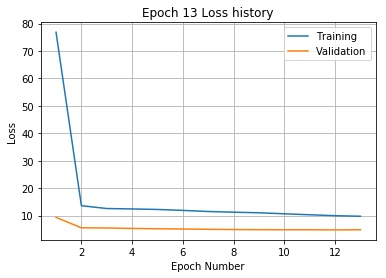

Training
Iteration 0: with minibatch training loss = 8.57 and relative error of 0.33
Iteration 20: with minibatch training loss = 7.73 and relative error of 0.32
Iteration 40: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 60: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 80: with minibatch training loss = 8.76 and relative error of 0.35
Iteration 100: with minibatch training loss = 11.3 and relative error of 0.37
Iteration 120: with minibatch training loss = 5.59 and relative error of 0.27
Iteration 140: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 160: with minibatch training loss = 7.6 and relative error of 0.33
Iteration 180: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 200: with minibatch training loss = 12.7 and relative error of 0.39
Iteration 220: with minibatch training loss = 9.63 and relative error of 0.35
Iteration 240: with minibatch training loss = 10.4 and relative

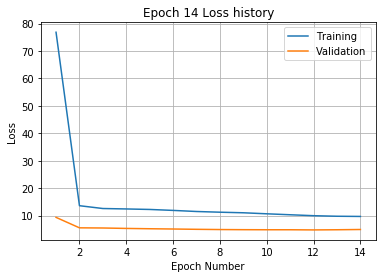

Training
Iteration 0: with minibatch training loss = 8.95 and relative error of 0.35
Iteration 20: with minibatch training loss = 8.49 and relative error of 0.34
Iteration 40: with minibatch training loss = 8.53 and relative error of 0.33
Iteration 60: with minibatch training loss = 7.56 and relative error of 0.3
Iteration 80: with minibatch training loss = 8.38 and relative error of 0.33
Iteration 100: with minibatch training loss = 8.65 and relative error of 0.34
Iteration 120: with minibatch training loss = 12 and relative error of 0.39
Iteration 140: with minibatch training loss = 9.06 and relative error of 0.35
Iteration 160: with minibatch training loss = 9.86 and relative error of 0.37
Iteration 180: with minibatch training loss = 6.11 and relative error of 0.28
Iteration 200: with minibatch training loss = 7.37 and relative error of 0.31
Iteration 220: with minibatch training loss = 8.78 and relative error of 0.35
Iteration 240: with minibatch training loss = 9.29 and relative 

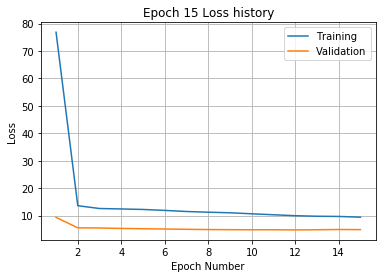

Training
Iteration 0: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 20: with minibatch training loss = 7.02 and relative error of 0.3
Iteration 40: with minibatch training loss = 9.62 and relative error of 0.34
Iteration 60: with minibatch training loss = 8.38 and relative error of 0.33
Iteration 80: with minibatch training loss = 8.82 and relative error of 0.34
Iteration 100: with minibatch training loss = 7.37 and relative error of 0.31
Iteration 120: with minibatch training loss = 13 and relative error of 0.41
Iteration 140: with minibatch training loss = 7.63 and relative error of 0.32
Iteration 160: with minibatch training loss = 7.82 and relative error of 0.32
Iteration 180: with minibatch training loss = 10.7 and relative error of 0.38
Iteration 200: with minibatch training loss = 9.87 and relative error of 0.36
Iteration 220: with minibatch training loss = 8.43 and relative error of 0.33
Iteration 240: with minibatch training loss = 8.55 and relative 

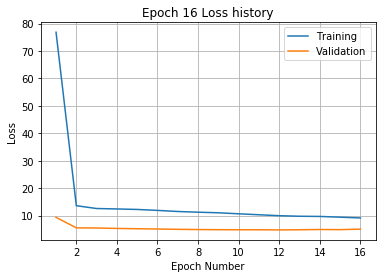

Training
Iteration 0: with minibatch training loss = 7.19 and relative error of 0.3
Iteration 20: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 40: with minibatch training loss = 11.7 and relative error of 0.41
Iteration 60: with minibatch training loss = 9.54 and relative error of 0.36
Iteration 80: with minibatch training loss = 7.7 and relative error of 0.31
Iteration 100: with minibatch training loss = 8.79 and relative error of 0.34
Iteration 120: with minibatch training loss = 7.4 and relative error of 0.31
Iteration 140: with minibatch training loss = 9.99 and relative error of 0.36
Iteration 160: with minibatch training loss = 9.63 and relative error of 0.36
Iteration 180: with minibatch training loss = 8.81 and relative error of 0.35
Iteration 200: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 220: with minibatch training loss = 6.7 and relative error of 0.3
Iteration 240: with minibatch training loss = 10.7 and relative er

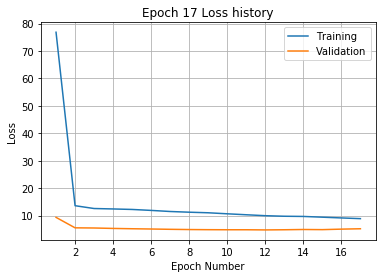

Validation error has stopped improving! Training on repetition 6 stopped!
Training
Iteration 0: with minibatch training loss = 168 and relative error of 1.5
Iteration 20: with minibatch training loss = 127 and relative error of 1.3
Iteration 40: with minibatch training loss = 101 and relative error of 1.2
Iteration 60: with minibatch training loss = 86.3 and relative error of 1
Iteration 80: with minibatch training loss = 59.9 and relative error of 0.9
Iteration 100: with minibatch training loss = 43.5 and relative error of 0.74
Iteration 120: with minibatch training loss = 33.6 and relative error of 0.65
Iteration 140: with minibatch training loss = 28.4 and relative error of 0.61
Iteration 160: with minibatch training loss = 22.4 and relative error of 0.54
Iteration 180: with minibatch training loss = 21.4 and relative error of 0.51
Iteration 200: with minibatch training loss = 18.4 and relative error of 0.49
Iteration 220: with minibatch training loss = 14.3 and relative error of 0.

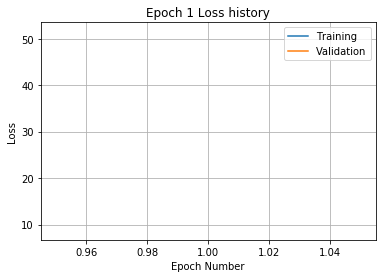

Training
Iteration 0: with minibatch training loss = 13 and relative error of 0.42
Iteration 20: with minibatch training loss = 13 and relative error of 0.42
Iteration 40: with minibatch training loss = 11.7 and relative error of 0.4
Iteration 60: with minibatch training loss = 14.2 and relative error of 0.43
Iteration 80: with minibatch training loss = 12.9 and relative error of 0.4
Iteration 100: with minibatch training loss = 13.8 and relative error of 0.41
Iteration 120: with minibatch training loss = 15 and relative error of 0.42
Iteration 140: with minibatch training loss = 10.5 and relative error of 0.35
Iteration 160: with minibatch training loss = 13.7 and relative error of 0.41
Iteration 180: with minibatch training loss = 13.8 and relative error of 0.41
Iteration 200: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 220: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 240: with minibatch training loss = 11.1 and relative error

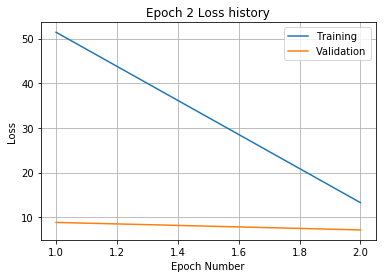

Training
Iteration 0: with minibatch training loss = 16.4 and relative error of 0.44
Iteration 20: with minibatch training loss = 13.2 and relative error of 0.41
Iteration 40: with minibatch training loss = 15.4 and relative error of 0.43
Iteration 60: with minibatch training loss = 14.5 and relative error of 0.42
Iteration 80: with minibatch training loss = 16.2 and relative error of 0.46
Iteration 100: with minibatch training loss = 15 and relative error of 0.45
Iteration 120: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 140: with minibatch training loss = 15.2 and relative error of 0.45
Iteration 160: with minibatch training loss = 13.5 and relative error of 0.41
Iteration 180: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 200: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 220: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 240: with minibatch training loss = 12.3 and relative

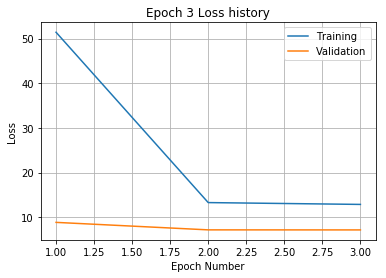

Training
Iteration 0: with minibatch training loss = 11.6 and relative error of 0.37
Iteration 20: with minibatch training loss = 8.35 and relative error of 0.33
Iteration 40: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 60: with minibatch training loss = 15.6 and relative error of 0.45
Iteration 80: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 100: with minibatch training loss = 14.5 and relative error of 0.43
Iteration 120: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 140: with minibatch training loss = 11.2 and relative error of 0.4
Iteration 160: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 180: with minibatch training loss = 11.8 and relative error of 0.41
Iteration 200: with minibatch training loss = 11 and relative error of 0.37
Iteration 220: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 240: with minibatch training loss = 14.2 and relative 

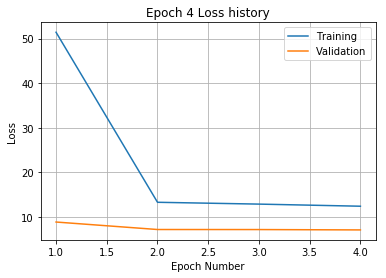

Training
Iteration 0: with minibatch training loss = 12.9 and relative error of 0.42
Iteration 20: with minibatch training loss = 9.25 and relative error of 0.35
Iteration 40: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 60: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 80: with minibatch training loss = 15 and relative error of 0.45
Iteration 100: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 120: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 140: with minibatch training loss = 9.78 and relative error of 0.35
Iteration 160: with minibatch training loss = 13.5 and relative error of 0.43
Iteration 180: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 200: with minibatch training loss = 13.9 and relative error of 0.42
Iteration 220: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 240: with minibatch training loss = 12.5 and relative er

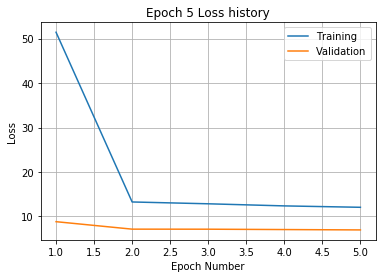

Training
Iteration 0: with minibatch training loss = 12.3 and relative error of 0.41
Iteration 20: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 40: with minibatch training loss = 16.7 and relative error of 0.47
Iteration 60: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 80: with minibatch training loss = 10.3 and relative error of 0.37
Iteration 100: with minibatch training loss = 12 and relative error of 0.4
Iteration 120: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 140: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 160: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 180: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 200: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 220: with minibatch training loss = 13.6 and relative error of 0.41
Iteration 240: with minibatch training loss = 13.4 and relative e

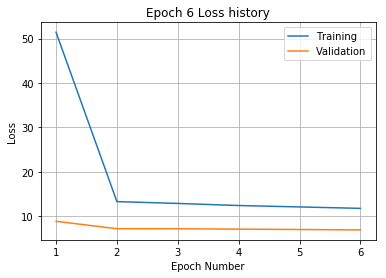

Training
Iteration 0: with minibatch training loss = 11.2 and relative error of 0.4
Iteration 20: with minibatch training loss = 11.6 and relative error of 0.4
Iteration 40: with minibatch training loss = 13.2 and relative error of 0.41
Iteration 60: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 80: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 100: with minibatch training loss = 9.27 and relative error of 0.35
Iteration 120: with minibatch training loss = 13.3 and relative error of 0.4
Iteration 140: with minibatch training loss = 9.18 and relative error of 0.34
Iteration 160: with minibatch training loss = 12.8 and relative error of 0.41
Iteration 180: with minibatch training loss = 15.1 and relative error of 0.44
Iteration 200: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 220: with minibatch training loss = 14.7 and relative error of 0.43
Iteration 240: with minibatch training loss = 10.8 and relative 

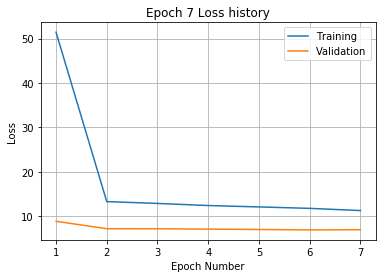

Training
Iteration 0: with minibatch training loss = 13.2 and relative error of 0.4
Iteration 20: with minibatch training loss = 9.06 and relative error of 0.34
Iteration 40: with minibatch training loss = 13.6 and relative error of 0.44
Iteration 60: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 80: with minibatch training loss = 12.7 and relative error of 0.39
Iteration 100: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 120: with minibatch training loss = 8.33 and relative error of 0.32
Iteration 140: with minibatch training loss = 12.1 and relative error of 0.41
Iteration 160: with minibatch training loss = 9.59 and relative error of 0.34
Iteration 180: with minibatch training loss = 9.09 and relative error of 0.35
Iteration 200: with minibatch training loss = 12.5 and relative error of 0.39
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 240: with minibatch training loss = 11.1 and relativ

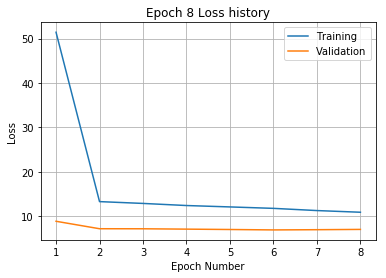

Training
Iteration 0: with minibatch training loss = 9.26 and relative error of 0.35
Iteration 20: with minibatch training loss = 15.9 and relative error of 0.45
Iteration 40: with minibatch training loss = 11 and relative error of 0.39
Iteration 60: with minibatch training loss = 11.7 and relative error of 0.4
Iteration 80: with minibatch training loss = 9.57 and relative error of 0.36
Iteration 100: with minibatch training loss = 11.5 and relative error of 0.37
Iteration 120: with minibatch training loss = 12.1 and relative error of 0.4
Iteration 140: with minibatch training loss = 12.8 and relative error of 0.42
Iteration 160: with minibatch training loss = 9.67 and relative error of 0.34
Iteration 180: with minibatch training loss = 9.98 and relative error of 0.36
Iteration 200: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 220: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 240: with minibatch training loss = 8.59 and relative e

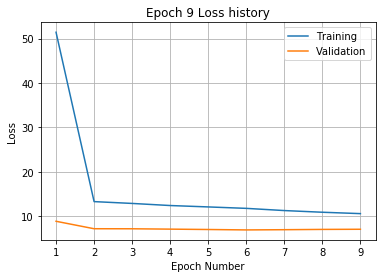

Training
Iteration 0: with minibatch training loss = 10.8 and relative error of 0.36
Iteration 20: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 40: with minibatch training loss = 9.8 and relative error of 0.35
Iteration 60: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 80: with minibatch training loss = 9.33 and relative error of 0.35
Iteration 100: with minibatch training loss = 15.2 and relative error of 0.42
Iteration 120: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 140: with minibatch training loss = 9.79 and relative error of 0.36
Iteration 160: with minibatch training loss = 12.5 and relative error of 0.39
Iteration 180: with minibatch training loss = 11.7 and relative error of 0.4
Iteration 200: with minibatch training loss = 9.04 and relative error of 0.35
Iteration 220: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 240: with minibatch training loss = 10.9 and relative

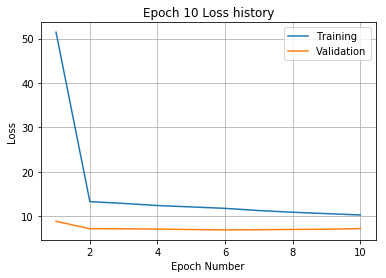

Training
Iteration 0: with minibatch training loss = 11.5 and relative error of 0.37
Iteration 20: with minibatch training loss = 8.71 and relative error of 0.35
Iteration 40: with minibatch training loss = 9.91 and relative error of 0.34
Iteration 60: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 80: with minibatch training loss = 9.93 and relative error of 0.35
Iteration 100: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 120: with minibatch training loss = 8.62 and relative error of 0.33
Iteration 140: with minibatch training loss = 7.86 and relative error of 0.31
Iteration 160: with minibatch training loss = 7.73 and relative error of 0.31
Iteration 180: with minibatch training loss = 8.82 and relative error of 0.34
Iteration 200: with minibatch training loss = 7.87 and relative error of 0.34
Iteration 220: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 240: with minibatch training loss = 10.8 and relati

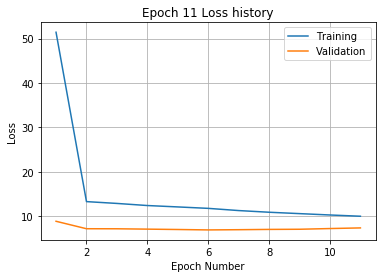

Validation error has stopped improving! Training on repetition 7 stopped!
Training
Iteration 0: with minibatch training loss = 231 and relative error of 1.7
Iteration 20: with minibatch training loss = 204 and relative error of 1.6
Iteration 40: with minibatch training loss = 172 and relative error of 1.5
Iteration 60: with minibatch training loss = 136 and relative error of 1.3
Iteration 80: with minibatch training loss = 102 and relative error of 1.2
Iteration 100: with minibatch training loss = 99.8 and relative error of 1.1
Iteration 120: with minibatch training loss = 79.3 and relative error of 0.99
Iteration 140: with minibatch training loss = 58.4 and relative error of 0.87
Iteration 160: with minibatch training loss = 56.4 and relative error of 0.85
Iteration 180: with minibatch training loss = 40.4 and relative error of 0.71
Iteration 200: with minibatch training loss = 26.1 and relative error of 0.58
Iteration 220: with minibatch training loss = 23.1 and relative error of 0.5

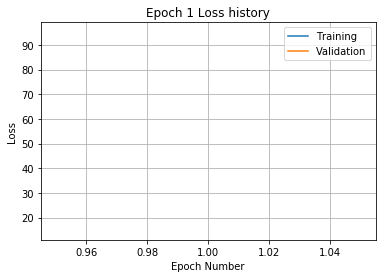

Training
Iteration 0: with minibatch training loss = 22.3 and relative error of 0.54
Iteration 20: with minibatch training loss = 21.2 and relative error of 0.52
Iteration 40: with minibatch training loss = 15.5 and relative error of 0.45
Iteration 60: with minibatch training loss = 18.1 and relative error of 0.48
Iteration 80: with minibatch training loss = 16.5 and relative error of 0.48
Iteration 100: with minibatch training loss = 14.4 and relative error of 0.42
Iteration 120: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 140: with minibatch training loss = 13.8 and relative error of 0.43
Iteration 160: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 180: with minibatch training loss = 15.3 and relative error of 0.44
Iteration 200: with minibatch training loss = 12.6 and relative error of 0.4
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 240: with minibatch training loss = 15.5 and relative

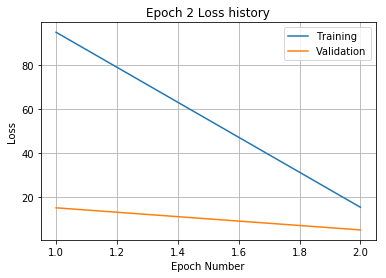

Training
Iteration 0: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 20: with minibatch training loss = 12.4 and relative error of 0.39
Iteration 40: with minibatch training loss = 11 and relative error of 0.39
Iteration 60: with minibatch training loss = 14.9 and relative error of 0.44
Iteration 80: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 100: with minibatch training loss = 13.1 and relative error of 0.4
Iteration 120: with minibatch training loss = 14.9 and relative error of 0.43
Iteration 140: with minibatch training loss = 13.8 and relative error of 0.43
Iteration 160: with minibatch training loss = 10.7 and relative error of 0.38
Iteration 180: with minibatch training loss = 14.8 and relative error of 0.43
Iteration 200: with minibatch training loss = 13.6 and relative error of 0.41
Iteration 220: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 240: with minibatch training loss = 11.4 and relative 

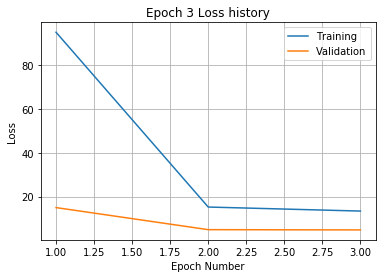

Training
Iteration 0: with minibatch training loss = 17.4 and relative error of 0.47
Iteration 20: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 40: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 60: with minibatch training loss = 11.3 and relative error of 0.4
Iteration 80: with minibatch training loss = 13.5 and relative error of 0.41
Iteration 100: with minibatch training loss = 13.6 and relative error of 0.43
Iteration 120: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 140: with minibatch training loss = 13.3 and relative error of 0.42
Iteration 160: with minibatch training loss = 13.5 and relative error of 0.44
Iteration 180: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 200: with minibatch training loss = 13.2 and relative error of 0.43
Iteration 220: with minibatch training loss = 11.5 and relative error of 0.37
Iteration 240: with minibatch training loss = 11.3 and relative

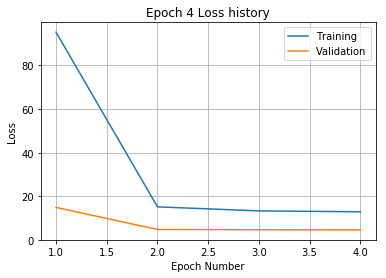

Training
Iteration 0: with minibatch training loss = 15.9 and relative error of 0.46
Iteration 20: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 40: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 60: with minibatch training loss = 12 and relative error of 0.37
Iteration 80: with minibatch training loss = 16.2 and relative error of 0.45
Iteration 100: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 120: with minibatch training loss = 9.98 and relative error of 0.36
Iteration 140: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 160: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 180: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 200: with minibatch training loss = 13 and relative error of 0.42
Iteration 220: with minibatch training loss = 11 and relative error of 0.38
Iteration 240: with minibatch training loss = 12.2 and relative err

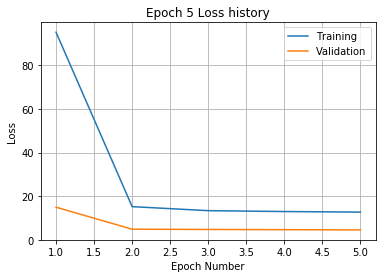

Training
Iteration 0: with minibatch training loss = 12.6 and relative error of 0.42
Iteration 20: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 40: with minibatch training loss = 13.8 and relative error of 0.41
Iteration 60: with minibatch training loss = 16.3 and relative error of 0.46
Iteration 80: with minibatch training loss = 14.6 and relative error of 0.44
Iteration 100: with minibatch training loss = 10.1 and relative error of 0.37
Iteration 120: with minibatch training loss = 15.2 and relative error of 0.42
Iteration 140: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 160: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 180: with minibatch training loss = 8.48 and relative error of 0.33
Iteration 200: with minibatch training loss = 15.4 and relative error of 0.44
Iteration 220: with minibatch training loss = 7.47 and relative error of 0.32
Iteration 240: with minibatch training loss = 11 and relative

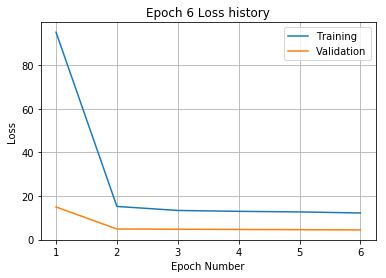

Training
Iteration 0: with minibatch training loss = 12.8 and relative error of 0.42
Iteration 20: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 40: with minibatch training loss = 12.9 and relative error of 0.4
Iteration 60: with minibatch training loss = 9.11 and relative error of 0.34
Iteration 80: with minibatch training loss = 12.7 and relative error of 0.39
Iteration 100: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 120: with minibatch training loss = 14.3 and relative error of 0.46
Iteration 140: with minibatch training loss = 10 and relative error of 0.35
Iteration 160: with minibatch training loss = 11.8 and relative error of 0.38
Iteration 180: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 200: with minibatch training loss = 10.7 and relative error of 0.38
Iteration 220: with minibatch training loss = 13.7 and relative error of 0.44
Iteration 240: with minibatch training loss = 11.7 and relative 

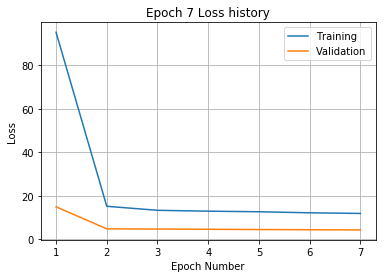

Training
Iteration 0: with minibatch training loss = 8.99 and relative error of 0.34
Iteration 20: with minibatch training loss = 12.5 and relative error of 0.39
Iteration 40: with minibatch training loss = 8.31 and relative error of 0.33
Iteration 60: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 80: with minibatch training loss = 12.1 and relative error of 0.38
Iteration 100: with minibatch training loss = 9.5 and relative error of 0.36
Iteration 120: with minibatch training loss = 14.4 and relative error of 0.42
Iteration 140: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 160: with minibatch training loss = 15.1 and relative error of 0.44
Iteration 180: with minibatch training loss = 13.1 and relative error of 0.43
Iteration 200: with minibatch training loss = 9.86 and relative error of 0.36
Iteration 220: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 240: with minibatch training loss = 10.7 and relativ

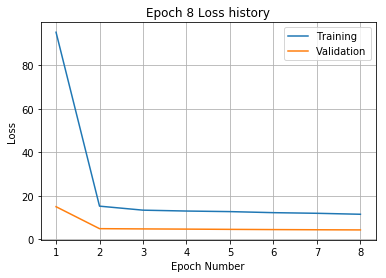

Training
Iteration 0: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 20: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 40: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 60: with minibatch training loss = 12.7 and relative error of 0.4
Iteration 80: with minibatch training loss = 10.1 and relative error of 0.37
Iteration 100: with minibatch training loss = 11.8 and relative error of 0.38
Iteration 120: with minibatch training loss = 9.39 and relative error of 0.35
Iteration 140: with minibatch training loss = 10.4 and relative error of 0.35
Iteration 160: with minibatch training loss = 10.4 and relative error of 0.37
Iteration 180: with minibatch training loss = 8.89 and relative error of 0.33
Iteration 200: with minibatch training loss = 14 and relative error of 0.44
Iteration 220: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 240: with minibatch training loss = 10.6 and relative 

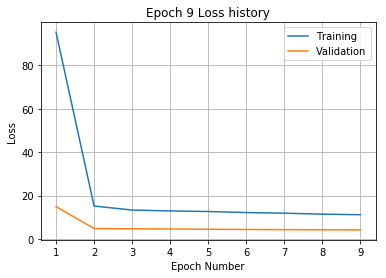

Training
Iteration 0: with minibatch training loss = 7.71 and relative error of 0.31
Iteration 20: with minibatch training loss = 11.1 and relative error of 0.36
Iteration 40: with minibatch training loss = 11.9 and relative error of 0.37
Iteration 60: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 80: with minibatch training loss = 14.9 and relative error of 0.43
Iteration 100: with minibatch training loss = 11 and relative error of 0.38
Iteration 120: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 140: with minibatch training loss = 11.6 and relative error of 0.4
Iteration 160: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 180: with minibatch training loss = 8.95 and relative error of 0.34
Iteration 200: with minibatch training loss = 9.75 and relative error of 0.35
Iteration 220: with minibatch training loss = 12.4 and relative error of 0.41
Iteration 240: with minibatch training loss = 13.4 and relative 

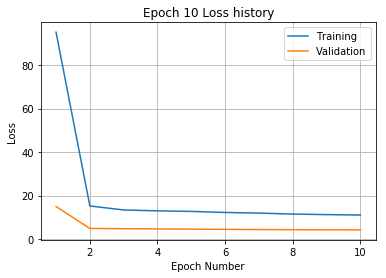

Training
Iteration 0: with minibatch training loss = 13.3 and relative error of 0.42
Iteration 20: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 40: with minibatch training loss = 14.4 and relative error of 0.43
Iteration 60: with minibatch training loss = 7.76 and relative error of 0.31
Iteration 80: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 100: with minibatch training loss = 14.6 and relative error of 0.44
Iteration 120: with minibatch training loss = 7.84 and relative error of 0.33
Iteration 140: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 160: with minibatch training loss = 10.4 and relative error of 0.37
Iteration 180: with minibatch training loss = 9.63 and relative error of 0.35
Iteration 200: with minibatch training loss = 9.79 and relative error of 0.35
Iteration 220: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 240: with minibatch training loss = 10.1 and relati

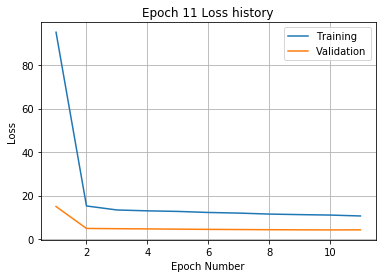

Training
Iteration 0: with minibatch training loss = 11 and relative error of 0.38
Iteration 20: with minibatch training loss = 9.1 and relative error of 0.35
Iteration 40: with minibatch training loss = 10 and relative error of 0.36
Iteration 60: with minibatch training loss = 9.82 and relative error of 0.36
Iteration 80: with minibatch training loss = 11 and relative error of 0.39
Iteration 100: with minibatch training loss = 8.64 and relative error of 0.34
Iteration 120: with minibatch training loss = 8.91 and relative error of 0.34
Iteration 140: with minibatch training loss = 6.72 and relative error of 0.3
Iteration 160: with minibatch training loss = 13.1 and relative error of 0.42
Iteration 180: with minibatch training loss = 9.75 and relative error of 0.35
Iteration 200: with minibatch training loss = 10.3 and relative error of 0.38
Iteration 220: with minibatch training loss = 12.2 and relative error of 0.39
Iteration 240: with minibatch training loss = 8.79 and relative error

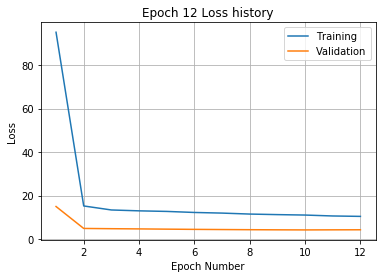

Training
Iteration 0: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 20: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 40: with minibatch training loss = 8.41 and relative error of 0.32
Iteration 60: with minibatch training loss = 9.33 and relative error of 0.35
Iteration 80: with minibatch training loss = 8.61 and relative error of 0.33
Iteration 100: with minibatch training loss = 8.99 and relative error of 0.34
Iteration 120: with minibatch training loss = 10.3 and relative error of 0.37
Iteration 140: with minibatch training loss = 7.89 and relative error of 0.32
Iteration 160: with minibatch training loss = 7.88 and relative error of 0.32
Iteration 180: with minibatch training loss = 9.8 and relative error of 0.36
Iteration 200: with minibatch training loss = 7.53 and relative error of 0.31
Iteration 220: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 240: with minibatch training loss = 9.24 and relativ

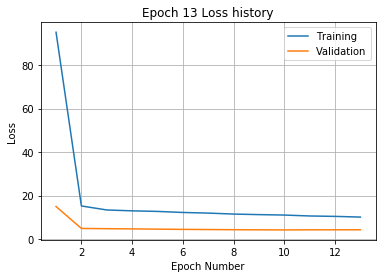

Training
Iteration 0: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 20: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 40: with minibatch training loss = 7.43 and relative error of 0.3
Iteration 60: with minibatch training loss = 8.38 and relative error of 0.33
Iteration 80: with minibatch training loss = 8.48 and relative error of 0.32
Iteration 100: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 120: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 140: with minibatch training loss = 8.22 and relative error of 0.33
Iteration 160: with minibatch training loss = 10.3 and relative error of 0.38
Iteration 180: with minibatch training loss = 9.31 and relative error of 0.35
Iteration 200: with minibatch training loss = 8.9 and relative error of 0.34
Iteration 220: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 240: with minibatch training loss = 7.56 and relative

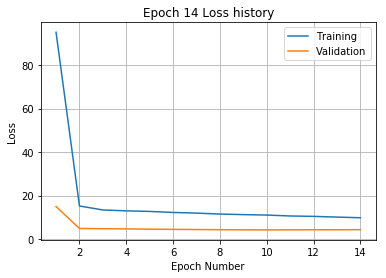

Training
Iteration 0: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 20: with minibatch training loss = 10.5 and relative error of 0.38
Iteration 40: with minibatch training loss = 14.1 and relative error of 0.45
Iteration 60: with minibatch training loss = 8.57 and relative error of 0.34
Iteration 80: with minibatch training loss = 8.42 and relative error of 0.32
Iteration 100: with minibatch training loss = 8.04 and relative error of 0.31
Iteration 120: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 140: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 160: with minibatch training loss = 9.38 and relative error of 0.36
Iteration 180: with minibatch training loss = 7.94 and relative error of 0.31
Iteration 200: with minibatch training loss = 6.91 and relative error of 0.28
Iteration 220: with minibatch training loss = 14.7 and relative error of 0.45
Iteration 240: with minibatch training loss = 7.56 and relati

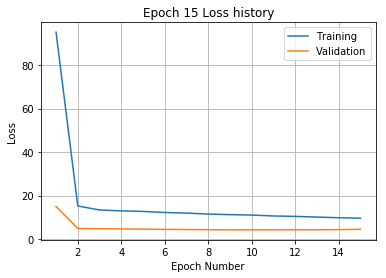

Validation error has stopped improving! Training on repetition 8 stopped!
Training
Iteration 0: with minibatch training loss = 261 and relative error of 1.8
Iteration 20: with minibatch training loss = 199 and relative error of 1.7
Iteration 40: with minibatch training loss = 162 and relative error of 1.5
Iteration 60: with minibatch training loss = 147 and relative error of 1.4
Iteration 80: with minibatch training loss = 125 and relative error of 1.3
Iteration 100: with minibatch training loss = 85.9 and relative error of 1.1
Iteration 120: with minibatch training loss = 78.9 and relative error of 0.97
Iteration 140: with minibatch training loss = 73.3 and relative error of 0.97
Iteration 160: with minibatch training loss = 50.7 and relative error of 0.81
Iteration 180: with minibatch training loss = 49.3 and relative error of 0.77
Iteration 200: with minibatch training loss = 32.6 and relative error of 0.64
Iteration 220: with minibatch training loss = 29.4 and relative error of 0.6

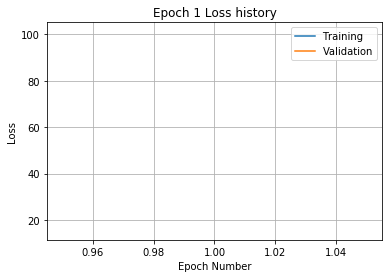

Training
Iteration 0: with minibatch training loss = 23.5 and relative error of 0.53
Iteration 20: with minibatch training loss = 21 and relative error of 0.51
Iteration 40: with minibatch training loss = 15.3 and relative error of 0.46
Iteration 60: with minibatch training loss = 14.7 and relative error of 0.43
Iteration 80: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 100: with minibatch training loss = 20.7 and relative error of 0.49
Iteration 120: with minibatch training loss = 13.2 and relative error of 0.41
Iteration 140: with minibatch training loss = 17.7 and relative error of 0.44
Iteration 160: with minibatch training loss = 12.7 and relative error of 0.4
Iteration 180: with minibatch training loss = 12.5 and relative error of 0.41
Iteration 200: with minibatch training loss = 12.2 and relative error of 0.41
Iteration 220: with minibatch training loss = 12.1 and relative error of 0.38
Iteration 240: with minibatch training loss = 13.4 and relative e

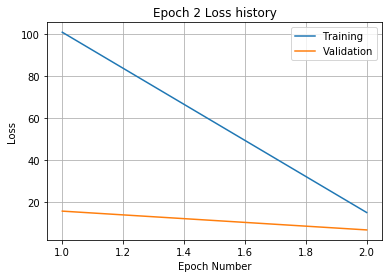

Training
Iteration 0: with minibatch training loss = 11.2 and relative error of 0.4
Iteration 20: with minibatch training loss = 11 and relative error of 0.37
Iteration 40: with minibatch training loss = 14.1 and relative error of 0.42
Iteration 60: with minibatch training loss = 12.7 and relative error of 0.39
Iteration 80: with minibatch training loss = 9.73 and relative error of 0.34
Iteration 100: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 120: with minibatch training loss = 9.67 and relative error of 0.37
Iteration 140: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 160: with minibatch training loss = 9.29 and relative error of 0.36
Iteration 180: with minibatch training loss = 13.5 and relative error of 0.43
Iteration 200: with minibatch training loss = 14.7 and relative error of 0.44
Iteration 220: with minibatch training loss = 11.9 and relative error of 0.38
Iteration 240: with minibatch training loss = 10.8 and relative 

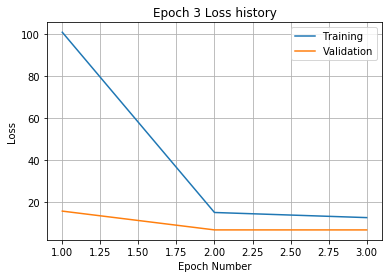

Training
Iteration 0: with minibatch training loss = 13 and relative error of 0.43
Iteration 20: with minibatch training loss = 11 and relative error of 0.37
Iteration 40: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 60: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 80: with minibatch training loss = 13.6 and relative error of 0.43
Iteration 100: with minibatch training loss = 13.1 and relative error of 0.42
Iteration 120: with minibatch training loss = 13.2 and relative error of 0.4
Iteration 140: with minibatch training loss = 11.2 and relative error of 0.39
Iteration 160: with minibatch training loss = 15.9 and relative error of 0.44
Iteration 180: with minibatch training loss = 15.3 and relative error of 0.42
Iteration 200: with minibatch training loss = 9.22 and relative error of 0.34
Iteration 220: with minibatch training loss = 12.1 and relative error of 0.4
Iteration 240: with minibatch training loss = 16.5 and relative erro

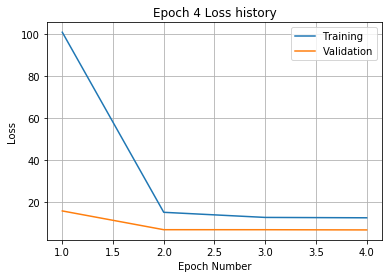

Training
Iteration 0: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 20: with minibatch training loss = 12.8 and relative error of 0.4
Iteration 40: with minibatch training loss = 13 and relative error of 0.4
Iteration 60: with minibatch training loss = 16.7 and relative error of 0.46
Iteration 80: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 100: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 120: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 140: with minibatch training loss = 11.6 and relative error of 0.4
Iteration 160: with minibatch training loss = 13.5 and relative error of 0.41
Iteration 180: with minibatch training loss = 11.9 and relative error of 0.42
Iteration 200: with minibatch training loss = 14 and relative error of 0.42
Iteration 220: with minibatch training loss = 12.4 and relative error of 0.39
Iteration 240: with minibatch training loss = 11.3 and relative error

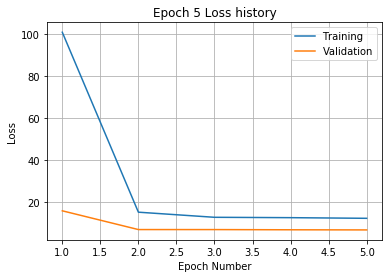

Training
Iteration 0: with minibatch training loss = 9.79 and relative error of 0.35
Iteration 20: with minibatch training loss = 13 and relative error of 0.39
Iteration 40: with minibatch training loss = 13.8 and relative error of 0.44
Iteration 60: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 80: with minibatch training loss = 8.72 and relative error of 0.33
Iteration 100: with minibatch training loss = 11 and relative error of 0.37
Iteration 120: with minibatch training loss = 13.8 and relative error of 0.41
Iteration 140: with minibatch training loss = 12 and relative error of 0.4
Iteration 160: with minibatch training loss = 8.91 and relative error of 0.35
Iteration 180: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 200: with minibatch training loss = 9.19 and relative error of 0.34
Iteration 220: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 240: with minibatch training loss = 14 and relative error 

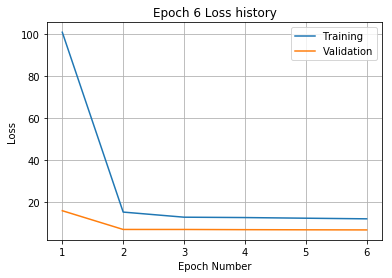

Training
Iteration 0: with minibatch training loss = 14.4 and relative error of 0.43
Iteration 20: with minibatch training loss = 10.1 and relative error of 0.37
Iteration 40: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 60: with minibatch training loss = 11 and relative error of 0.37
Iteration 80: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 100: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 120: with minibatch training loss = 10 and relative error of 0.35
Iteration 140: with minibatch training loss = 9.26 and relative error of 0.35
Iteration 160: with minibatch training loss = 10.9 and relative error of 0.39
Iteration 180: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 200: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 220: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 240: with minibatch training loss = 11.9 and relative er

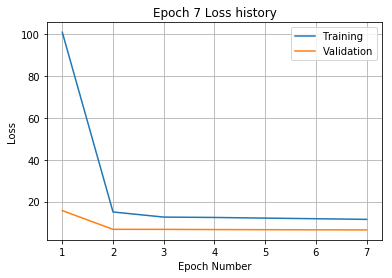

Training
Iteration 0: with minibatch training loss = 11.2 and relative error of 0.37
Iteration 20: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 40: with minibatch training loss = 12.7 and relative error of 0.4
Iteration 60: with minibatch training loss = 11.3 and relative error of 0.36
Iteration 80: with minibatch training loss = 9.69 and relative error of 0.34
Iteration 100: with minibatch training loss = 7.73 and relative error of 0.31
Iteration 120: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 140: with minibatch training loss = 11.1 and relative error of 0.37
Iteration 160: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 180: with minibatch training loss = 9.45 and relative error of 0.35
Iteration 200: with minibatch training loss = 9.94 and relative error of 0.37
Iteration 220: with minibatch training loss = 11 and relative error of 0.38
Iteration 240: with minibatch training loss = 10.1 and relative err

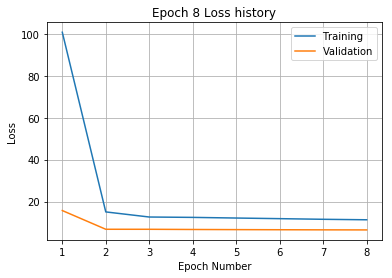

Training
Iteration 0: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 20: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 40: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 60: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 80: with minibatch training loss = 7.87 and relative error of 0.33
Iteration 100: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 120: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 140: with minibatch training loss = 14.8 and relative error of 0.44
Iteration 160: with minibatch training loss = 14.3 and relative error of 0.42
Iteration 180: with minibatch training loss = 10.3 and relative error of 0.34
Iteration 200: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 220: with minibatch training loss = 9.78 and relative error of 0.35
Iteration 240: with minibatch training loss = 8.61 and relati

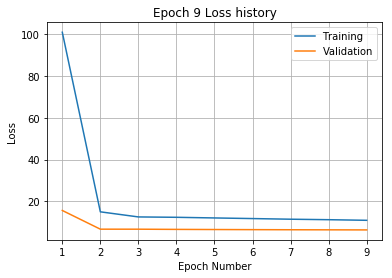

Training
Iteration 0: with minibatch training loss = 13.1 and relative error of 0.4
Iteration 20: with minibatch training loss = 9.98 and relative error of 0.35
Iteration 40: with minibatch training loss = 9.65 and relative error of 0.35
Iteration 60: with minibatch training loss = 7.68 and relative error of 0.31
Iteration 80: with minibatch training loss = 15.2 and relative error of 0.46
Iteration 100: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 120: with minibatch training loss = 13.1 and relative error of 0.42
Iteration 140: with minibatch training loss = 8.23 and relative error of 0.34
Iteration 160: with minibatch training loss = 9.08 and relative error of 0.34
Iteration 180: with minibatch training loss = 8.78 and relative error of 0.34
Iteration 200: with minibatch training loss = 12.4 and relative error of 0.39
Iteration 220: with minibatch training loss = 10 and relative error of 0.35
Iteration 240: with minibatch training loss = 10.1 and relative e

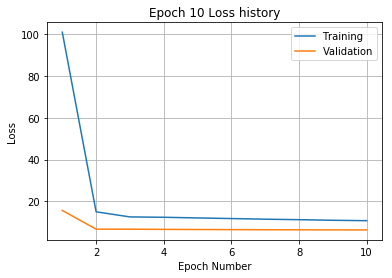

Training
Iteration 0: with minibatch training loss = 13.8 and relative error of 0.42
Iteration 20: with minibatch training loss = 13 and relative error of 0.41
Iteration 40: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 60: with minibatch training loss = 10.8 and relative error of 0.36
Iteration 80: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 100: with minibatch training loss = 9.78 and relative error of 0.37
Iteration 120: with minibatch training loss = 9.23 and relative error of 0.33
Iteration 140: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 160: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 180: with minibatch training loss = 10.1 and relative error of 0.37
Iteration 200: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 220: with minibatch training loss = 13 and relative error of 0.41
Iteration 240: with minibatch training loss = 11.8 and relative err

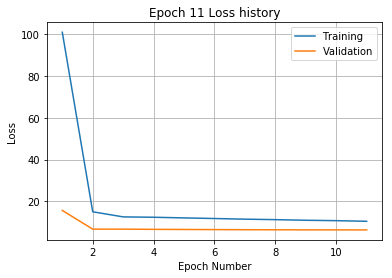

Training
Iteration 0: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 20: with minibatch training loss = 8.49 and relative error of 0.33
Iteration 40: with minibatch training loss = 8.77 and relative error of 0.33
Iteration 60: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 80: with minibatch training loss = 9.02 and relative error of 0.33
Iteration 100: with minibatch training loss = 9.82 and relative error of 0.37
Iteration 120: with minibatch training loss = 12.3 and relative error of 0.39
Iteration 140: with minibatch training loss = 16.6 and relative error of 0.45
Iteration 160: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 180: with minibatch training loss = 7.67 and relative error of 0.31
Iteration 200: with minibatch training loss = 9.1 and relative error of 0.34
Iteration 220: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 240: with minibatch training loss = 9.43 and relative

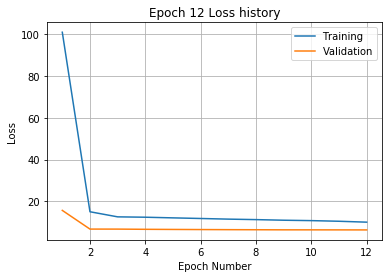

Training
Iteration 0: with minibatch training loss = 10.3 and relative error of 0.37
Iteration 20: with minibatch training loss = 11 and relative error of 0.38
Iteration 40: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 60: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 80: with minibatch training loss = 9.95 and relative error of 0.35
Iteration 100: with minibatch training loss = 9.99 and relative error of 0.37
Iteration 120: with minibatch training loss = 8.81 and relative error of 0.33
Iteration 140: with minibatch training loss = 7.42 and relative error of 0.31
Iteration 160: with minibatch training loss = 11.3 and relative error of 0.38
Iteration 180: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 200: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 220: with minibatch training loss = 7.91 and relative error of 0.32
Iteration 240: with minibatch training loss = 9.79 and relative

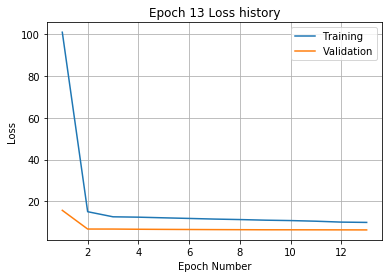

Training
Iteration 0: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 20: with minibatch training loss = 8.17 and relative error of 0.33
Iteration 40: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 60: with minibatch training loss = 6.25 and relative error of 0.27
Iteration 80: with minibatch training loss = 6.99 and relative error of 0.3
Iteration 100: with minibatch training loss = 8.63 and relative error of 0.32
Iteration 120: with minibatch training loss = 9.89 and relative error of 0.35
Iteration 140: with minibatch training loss = 9.39 and relative error of 0.35
Iteration 160: with minibatch training loss = 6.91 and relative error of 0.3
Iteration 180: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 200: with minibatch training loss = 9.11 and relative error of 0.34
Iteration 220: with minibatch training loss = 10.3 and relative error of 0.37
Iteration 240: with minibatch training loss = 8.95 and relative

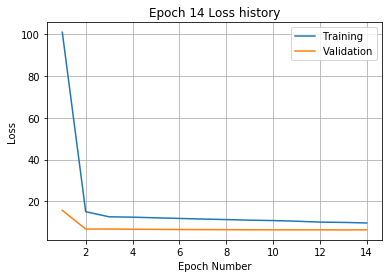

Training
Iteration 0: with minibatch training loss = 8.29 and relative error of 0.32
Iteration 20: with minibatch training loss = 9.82 and relative error of 0.36
Iteration 40: with minibatch training loss = 11 and relative error of 0.37
Iteration 60: with minibatch training loss = 8.15 and relative error of 0.32
Iteration 80: with minibatch training loss = 9.52 and relative error of 0.35
Iteration 100: with minibatch training loss = 9.66 and relative error of 0.35
Iteration 120: with minibatch training loss = 9.02 and relative error of 0.33
Iteration 140: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 160: with minibatch training loss = 8.02 and relative error of 0.31
Iteration 180: with minibatch training loss = 8.07 and relative error of 0.31
Iteration 200: with minibatch training loss = 9.86 and relative error of 0.36
Iteration 220: with minibatch training loss = 9.49 and relative error of 0.35
Iteration 240: with minibatch training loss = 8.55 and relative

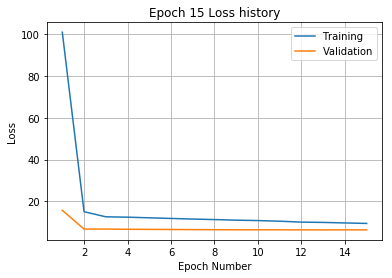

Training
Iteration 0: with minibatch training loss = 8.75 and relative error of 0.33
Iteration 20: with minibatch training loss = 9.84 and relative error of 0.37
Iteration 40: with minibatch training loss = 10 and relative error of 0.37
Iteration 60: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 80: with minibatch training loss = 8.68 and relative error of 0.33
Iteration 100: with minibatch training loss = 9.04 and relative error of 0.34
Iteration 120: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 140: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 160: with minibatch training loss = 8.22 and relative error of 0.32
Iteration 180: with minibatch training loss = 13.2 and relative error of 0.41
Iteration 200: with minibatch training loss = 7.4 and relative error of 0.31
Iteration 220: with minibatch training loss = 9.59 and relative error of 0.35
Iteration 240: with minibatch training loss = 8.14 and relative 

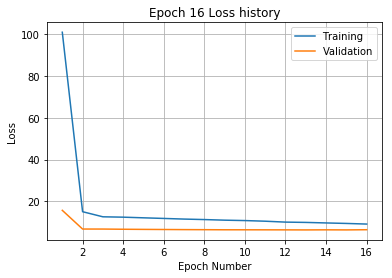

Training
Iteration 0: with minibatch training loss = 9.63 and relative error of 0.35
Iteration 20: with minibatch training loss = 9.64 and relative error of 0.36
Iteration 40: with minibatch training loss = 9.02 and relative error of 0.34
Iteration 60: with minibatch training loss = 10.1 and relative error of 0.37
Iteration 80: with minibatch training loss = 12.8 and relative error of 0.4
Iteration 100: with minibatch training loss = 9.57 and relative error of 0.35
Iteration 120: with minibatch training loss = 11.4 and relative error of 0.4
Iteration 140: with minibatch training loss = 8.58 and relative error of 0.34
Iteration 160: with minibatch training loss = 8.37 and relative error of 0.33
Iteration 180: with minibatch training loss = 6.5 and relative error of 0.29
Iteration 200: with minibatch training loss = 8.25 and relative error of 0.31
Iteration 220: with minibatch training loss = 7.96 and relative error of 0.32
Iteration 240: with minibatch training loss = 8.06 and relative 

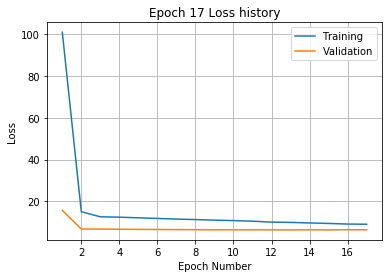

Training
Iteration 0: with minibatch training loss = 11 and relative error of 0.37
Iteration 20: with minibatch training loss = 6.01 and relative error of 0.28
Iteration 40: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 60: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 80: with minibatch training loss = 6.36 and relative error of 0.28
Iteration 100: with minibatch training loss = 7.78 and relative error of 0.33
Iteration 120: with minibatch training loss = 12 and relative error of 0.38
Iteration 140: with minibatch training loss = 9.33 and relative error of 0.33
Iteration 160: with minibatch training loss = 9.43 and relative error of 0.35
Iteration 180: with minibatch training loss = 9.43 and relative error of 0.34
Iteration 200: with minibatch training loss = 9.91 and relative error of 0.36
Iteration 220: with minibatch training loss = 8.71 and relative error of 0.33
Iteration 240: with minibatch training loss = 13.1 and relative e

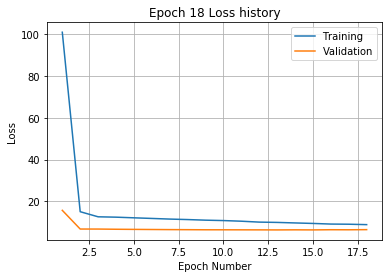

Validation error has stopped improving! Training on repetition 9 stopped!
Training
Iteration 0: with minibatch training loss = 203 and relative error of 1.6
Iteration 20: with minibatch training loss = 160 and relative error of 1.4
Iteration 40: with minibatch training loss = 114 and relative error of 1.2
Iteration 60: with minibatch training loss = 93.6 and relative error of 1.1
Iteration 80: with minibatch training loss = 59.1 and relative error of 0.89
Iteration 100: with minibatch training loss = 57.9 and relative error of 0.85
Iteration 120: with minibatch training loss = 51 and relative error of 0.82
Iteration 140: with minibatch training loss = 36.3 and relative error of 0.69
Iteration 160: with minibatch training loss = 27.2 and relative error of 0.59
Iteration 180: with minibatch training loss = 25.5 and relative error of 0.56
Iteration 200: with minibatch training loss = 22.2 and relative error of 0.54
Iteration 220: with minibatch training loss = 20.1 and relative error of 0

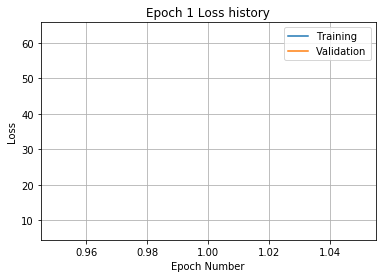

Training
Iteration 0: with minibatch training loss = 12.9 and relative error of 0.42
Iteration 20: with minibatch training loss = 15 and relative error of 0.44
Iteration 40: with minibatch training loss = 15 and relative error of 0.45
Iteration 60: with minibatch training loss = 15.9 and relative error of 0.47
Iteration 80: with minibatch training loss = 15.6 and relative error of 0.44
Iteration 100: with minibatch training loss = 15.8 and relative error of 0.44
Iteration 120: with minibatch training loss = 15.3 and relative error of 0.45
Iteration 140: with minibatch training loss = 11.7 and relative error of 0.41
Iteration 160: with minibatch training loss = 11.6 and relative error of 0.39
Iteration 180: with minibatch training loss = 17.1 and relative error of 0.47
Iteration 200: with minibatch training loss = 15.8 and relative error of 0.45
Iteration 220: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 240: with minibatch training loss = 17.4 and relative er

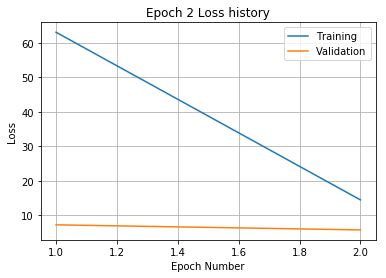

Training
Iteration 0: with minibatch training loss = 16.5 and relative error of 0.45
Iteration 20: with minibatch training loss = 13.9 and relative error of 0.43
Iteration 40: with minibatch training loss = 15.8 and relative error of 0.46
Iteration 60: with minibatch training loss = 14.4 and relative error of 0.44
Iteration 80: with minibatch training loss = 13.4 and relative error of 0.42
Iteration 100: with minibatch training loss = 14.9 and relative error of 0.43
Iteration 120: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 140: with minibatch training loss = 11.7 and relative error of 0.4
Iteration 160: with minibatch training loss = 15 and relative error of 0.45
Iteration 180: with minibatch training loss = 13.6 and relative error of 0.42
Iteration 200: with minibatch training loss = 13.7 and relative error of 0.44
Iteration 220: with minibatch training loss = 16.5 and relative error of 0.46
Iteration 240: with minibatch training loss = 14.3 and relative 

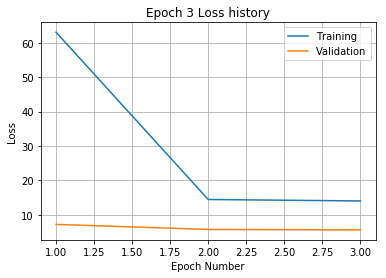

Training
Iteration 0: with minibatch training loss = 14.5 and relative error of 0.45
Iteration 20: with minibatch training loss = 15.6 and relative error of 0.44
Iteration 40: with minibatch training loss = 13.1 and relative error of 0.42
Iteration 60: with minibatch training loss = 12.8 and relative error of 0.41
Iteration 80: with minibatch training loss = 9.88 and relative error of 0.35
Iteration 100: with minibatch training loss = 12.6 and relative error of 0.4
Iteration 120: with minibatch training loss = 12 and relative error of 0.39
Iteration 140: with minibatch training loss = 11.2 and relative error of 0.37
Iteration 160: with minibatch training loss = 12.6 and relative error of 0.39
Iteration 180: with minibatch training loss = 13.9 and relative error of 0.43
Iteration 200: with minibatch training loss = 14.3 and relative error of 0.42
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 240: with minibatch training loss = 10.8 and relative 

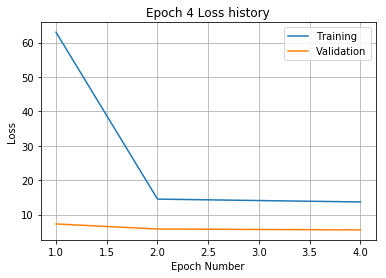

Training
Iteration 0: with minibatch training loss = 13.5 and relative error of 0.41
Iteration 20: with minibatch training loss = 14.4 and relative error of 0.44
Iteration 40: with minibatch training loss = 16.4 and relative error of 0.47
Iteration 60: with minibatch training loss = 11 and relative error of 0.37
Iteration 80: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 100: with minibatch training loss = 17.2 and relative error of 0.47
Iteration 120: with minibatch training loss = 12.8 and relative error of 0.4
Iteration 140: with minibatch training loss = 12.5 and relative error of 0.39
Iteration 160: with minibatch training loss = 15.4 and relative error of 0.46
Iteration 180: with minibatch training loss = 14.1 and relative error of 0.43
Iteration 200: with minibatch training loss = 14.2 and relative error of 0.43
Iteration 220: with minibatch training loss = 9.5 and relative error of 0.35
Iteration 240: with minibatch training loss = 13.4 and relative e

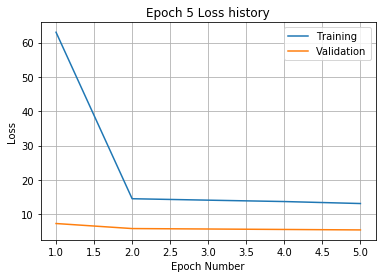

Training
Iteration 0: with minibatch training loss = 13.1 and relative error of 0.4
Iteration 20: with minibatch training loss = 14 and relative error of 0.43
Iteration 40: with minibatch training loss = 14.8 and relative error of 0.45
Iteration 60: with minibatch training loss = 14.8 and relative error of 0.44
Iteration 80: with minibatch training loss = 16.1 and relative error of 0.47
Iteration 100: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 120: with minibatch training loss = 11.9 and relative error of 0.38
Iteration 140: with minibatch training loss = 14.3 and relative error of 0.41
Iteration 160: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 180: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 200: with minibatch training loss = 10.2 and relative error of 0.39
Iteration 220: with minibatch training loss = 13 and relative error of 0.4
Iteration 240: with minibatch training loss = 13.5 and relative erro

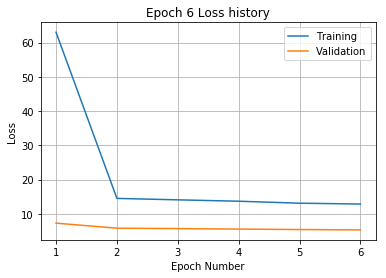

Training
Iteration 0: with minibatch training loss = 12.5 and relative error of 0.41
Iteration 20: with minibatch training loss = 10.4 and relative error of 0.35
Iteration 40: with minibatch training loss = 9.69 and relative error of 0.35
Iteration 60: with minibatch training loss = 15.5 and relative error of 0.46
Iteration 80: with minibatch training loss = 13.4 and relative error of 0.41
Iteration 100: with minibatch training loss = 13.3 and relative error of 0.4
Iteration 120: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 140: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 160: with minibatch training loss = 9.32 and relative error of 0.37
Iteration 180: with minibatch training loss = 9.46 and relative error of 0.35
Iteration 200: with minibatch training loss = 14.3 and relative error of 0.44
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 240: with minibatch training loss = 11.6 and relativ

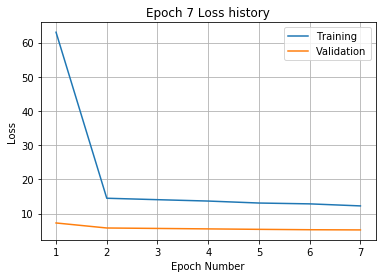

Training
Iteration 0: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 20: with minibatch training loss = 12.8 and relative error of 0.41
Iteration 40: with minibatch training loss = 10.8 and relative error of 0.39
Iteration 60: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 80: with minibatch training loss = 15.8 and relative error of 0.45
Iteration 100: with minibatch training loss = 12.1 and relative error of 0.39
Iteration 120: with minibatch training loss = 13.6 and relative error of 0.43
Iteration 140: with minibatch training loss = 11.9 and relative error of 0.38
Iteration 160: with minibatch training loss = 11.2 and relative error of 0.39
Iteration 180: with minibatch training loss = 15.9 and relative error of 0.47
Iteration 200: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 220: with minibatch training loss = 9.53 and relative error of 0.35
Iteration 240: with minibatch training loss = 13.5 and relati

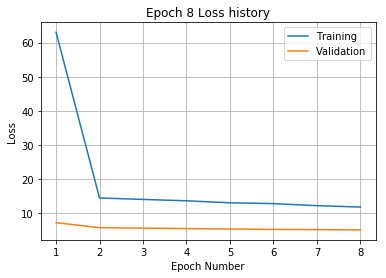

Training
Iteration 0: with minibatch training loss = 13.7 and relative error of 0.42
Iteration 20: with minibatch training loss = 10.7 and relative error of 0.38
Iteration 40: with minibatch training loss = 13.3 and relative error of 0.41
Iteration 60: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 80: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 100: with minibatch training loss = 13 and relative error of 0.41
Iteration 120: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 140: with minibatch training loss = 6.45 and relative error of 0.29
Iteration 160: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 180: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 200: with minibatch training loss = 10.4 and relative error of 0.35
Iteration 220: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 240: with minibatch training loss = 10.3 and relative

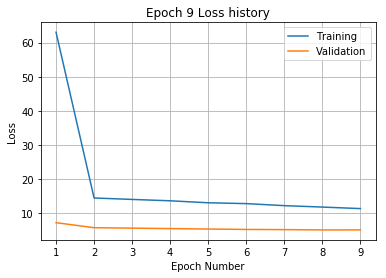

Training
Iteration 0: with minibatch training loss = 9.02 and relative error of 0.35
Iteration 20: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 40: with minibatch training loss = 9.48 and relative error of 0.34
Iteration 60: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 80: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 100: with minibatch training loss = 12.9 and relative error of 0.4
Iteration 120: with minibatch training loss = 12.4 and relative error of 0.4
Iteration 140: with minibatch training loss = 13.9 and relative error of 0.42
Iteration 160: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 180: with minibatch training loss = 13.5 and relative error of 0.41
Iteration 200: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 220: with minibatch training loss = 12.5 and relative error of 0.41
Iteration 240: with minibatch training loss = 10.6 and relative 

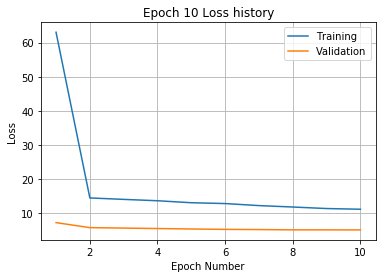

Training
Iteration 0: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 20: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 40: with minibatch training loss = 9.74 and relative error of 0.36
Iteration 60: with minibatch training loss = 10.4 and relative error of 0.35
Iteration 80: with minibatch training loss = 10.9 and relative error of 0.36
Iteration 100: with minibatch training loss = 15.2 and relative error of 0.43
Iteration 120: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 140: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 160: with minibatch training loss = 9.39 and relative error of 0.34
Iteration 180: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 200: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 220: with minibatch training loss = 9.06 and relative error of 0.35
Iteration 240: with minibatch training loss = 11.7 and relative

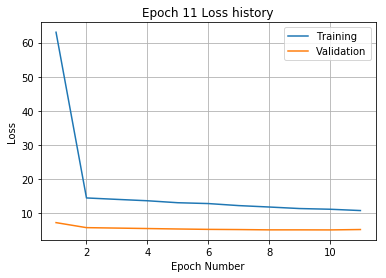

Training
Iteration 0: with minibatch training loss = 11 and relative error of 0.39
Iteration 20: with minibatch training loss = 9.81 and relative error of 0.36
Iteration 40: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 60: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 80: with minibatch training loss = 10.2 and relative error of 0.35
Iteration 100: with minibatch training loss = 9.84 and relative error of 0.35
Iteration 120: with minibatch training loss = 8.98 and relative error of 0.34
Iteration 140: with minibatch training loss = 7.15 and relative error of 0.3
Iteration 160: with minibatch training loss = 8.85 and relative error of 0.34
Iteration 180: with minibatch training loss = 10.4 and relative error of 0.38
Iteration 200: with minibatch training loss = 9.51 and relative error of 0.36
Iteration 220: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 240: with minibatch training loss = 7.61 and relative e

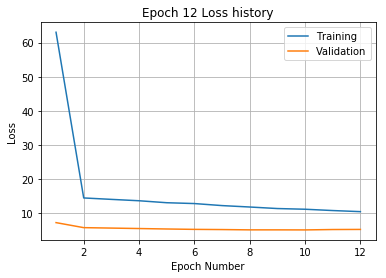

Training
Iteration 0: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 20: with minibatch training loss = 8.3 and relative error of 0.34
Iteration 40: with minibatch training loss = 10.8 and relative error of 0.36
Iteration 60: with minibatch training loss = 9.68 and relative error of 0.35
Iteration 80: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 100: with minibatch training loss = 9.1 and relative error of 0.33
Iteration 120: with minibatch training loss = 10.1 and relative error of 0.37
Iteration 140: with minibatch training loss = 10 and relative error of 0.36
Iteration 160: with minibatch training loss = 9.43 and relative error of 0.34
Iteration 180: with minibatch training loss = 9.96 and relative error of 0.36
Iteration 200: with minibatch training loss = 8.24 and relative error of 0.32
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.38
Iteration 240: with minibatch training loss = 10.4 and relative e

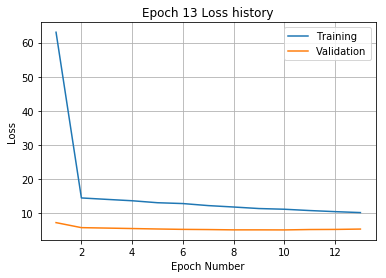

Training
Iteration 0: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 20: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 40: with minibatch training loss = 7.1 and relative error of 0.31
Iteration 60: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 80: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 100: with minibatch training loss = 7.25 and relative error of 0.31
Iteration 120: with minibatch training loss = 7.83 and relative error of 0.31
Iteration 140: with minibatch training loss = 9.03 and relative error of 0.34
Iteration 160: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 180: with minibatch training loss = 9.89 and relative error of 0.34
Iteration 200: with minibatch training loss = 9.59 and relative error of 0.36
Iteration 220: with minibatch training loss = 9.25 and relative error of 0.35
Iteration 240: with minibatch training loss = 8.24 and relative

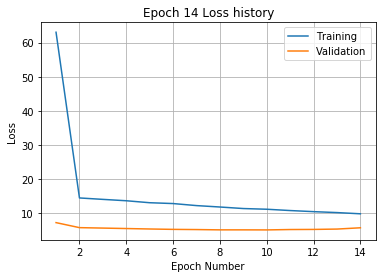

Training
Iteration 0: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 20: with minibatch training loss = 13.2 and relative error of 0.42
Iteration 40: with minibatch training loss = 8.97 and relative error of 0.33
Iteration 60: with minibatch training loss = 13.2 and relative error of 0.4
Iteration 80: with minibatch training loss = 8.63 and relative error of 0.34
Iteration 100: with minibatch training loss = 8.48 and relative error of 0.32
Iteration 120: with minibatch training loss = 8.94 and relative error of 0.35
Iteration 140: with minibatch training loss = 9.75 and relative error of 0.36
Iteration 160: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 180: with minibatch training loss = 9.02 and relative error of 0.34
Iteration 200: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 220: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 240: with minibatch training loss = 10.9 and relativ

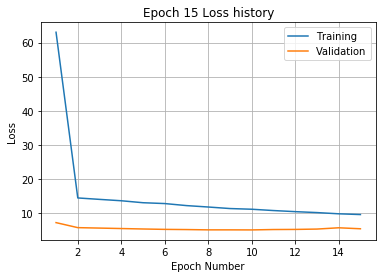

Validation error has stopped improving! Training on repetition 10 stopped!


In [6]:
# Create a list of variables and a list of data. They must have strict correspondence
Xy_var = [x2_var, y_var]
data_trainval = [pv_log_trainval,pv_pred_trainval]

# Run training process
save_path,training_history = run_training(num_rep, num_epochs, plotting, output_folder, model_name,"/gpu:2",
                                          Xy_var, is_training, loss_var, rel_err_var, train_step, data_trainval, 
                                          batch_size = batch_size)
                                          

# unpack the training history cache    
train_loss_hist,train_error_hist,val_loss_hist,val_error_hist = training_history

np.save(os.path.join(output_folder, "train_loss.npy"), train_loss_hist)
np.save(os.path.join(output_folder, "train_error.npy"), train_error_hist)
np.save(os.path.join(output_folder, "val_loss.npy"), val_loss_hist)
np.save(os.path.join(output_folder, "val_error.npy"), val_error_hist)


## Comparing mean validation loss

In [5]:
def find_best_loss(output_folder):
    # Restore error history
    train_loss = np.load(os.path.join(output_folder,"train_loss.npy"))
    val_loss = np.load(os.path.join(output_folder,"val_loss.npy"))
    
    num_rep = val_loss.shape[0]
    
    # Only obtain results for best model
    best_idx = np.zeros(num_rep,dtype =int)
    for i in range(num_rep):
        best_idx[i] = np.argmin(val_loss[i][val_loss[i]>0])

    train_best = train_loss[np.arange(num_rep),best_idx] 
    val_best = val_loss[np.arange(num_rep),best_idx]
    
    return [train_best,val_best]

In [6]:
## Find the persistence MSE
from Relative_op_func2 import Relative_output

# calculate the kt of the current time
kt_trainval,pv_log_trainval_theo = Relative_output(times_trainval, pv_log_trainval[:,0]) 
# kt = pv_log_test[:,0]/pv_log_test_theo

# calculate the P_theo in the future time
_,pv_pred_trainval_theo = Relative_output(times_trainval + datetime.timedelta(minutes = 15), pv_pred_trainval)

# forecast with kt_persistence
pv_pred_trainval_ktpers = kt_trainval*pv_pred_trainval_theo

# Find the MSE of the persistence model on trainval set
ktpers_mse_trainval = np.mean(np.square(pv_pred_trainval - pv_pred_trainval_ktpers))
print('kt-Persistence MSE of the trainval set: {0:.2f}'.format(ktpers_mse_trainval))

kt-Persistence MSE of the trainval set: 5.59


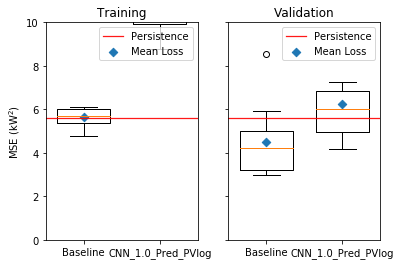

In [7]:
# Compare the training and validation loss boxchart with baseline model

baseline_model_name = 'CNN_1.0_Baseline'
output_folder_baseline = os.path.join('models',baseline_model_name)

best_loss_baseline = find_best_loss(output_folder_baseline)
best_loss_curr = find_best_loss(output_folder)


# Compare the rRMSE between this model and baseline model
f,axarr = plt.subplots(1,2,sharey = True)
set_name = ['Training','Validation']
model_label = ['Baseline', model_name]

for i in range(len(axarr)):
    best_loss = np.vstack((best_loss_baseline[i],best_loss_curr[i]))
    axarr[i].boxplot(best_loss.T, labels = model_label,widths = 0.7)
    
    axarr[i].set_title(set_name[i])
    axarr[i].grid(False)
    axarr[i].axhline(y=ktpers_mse_trainval,color= 'r',linewidth =1.25, alpha = 0.9, label = 'Persistence')
    
    # Plot the mean loss
    mean_loss = np.mean(best_loss,axis = 1)
    axarr[i].scatter(np.arange(1,len(model_label)+1), mean_loss, marker = 'D', label = 'Mean Loss')
    axarr[i].legend(loc = 'upper right')

axarr[0].set_ylabel('MSE $(\mathrm{kW}^2)$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.ylim(0,10)
plt.savefig(os.path.join(output_folder,'compare_to_baseline.png'),bbox_inches = 'tight')
plt.show()

## Deploying the model to the test set

In [8]:
# load PV output and images for the test
pv_log_test = np.load(pv_log_test_path)
images_test = np.load(image_log_test_path)
pv_pred_test = np.load(pv_pred_test_path)
times_test = np.load(os.path.join(times_test_path))

# stack up the log and color channels into a unified dimension
images_test = images_test.transpose((0,2,3,4,1))
images_test = images_test.reshape((images_test.shape[0],images_test.shape[1],images_test.shape[2],-1))

# Input dimension is used to construct the model
side_len = images_test.shape[1]
image_input_dim = [side_len,side_len,images_test.shape[3]]

In [9]:
# define variable and test data list [note the list here include training flag]
Xy_var_test = [x2_var, y_var]
data_test = [pv_log_test,pv_pred_test]

tic = time.process_time()

pred_y_value = inference_multirep(num_rep, model_name,output_folder,'/cpu:0', 
                                  Xy_var_test, is_training, pred_y_var, data_test)

toc = time.process_time() - tic

# Save the inference result
np.save(os.path.join('models',model_name,'pv_pred_test_modeled.npy'),np.mean(pred_y_value,axis = 0))

#Find the index of the first rainy day.
first_cloudy_idx = find_idx_with_dates(times_test, [first_cloudy_test])[0]

# Calculate bucket and single model MSE
bucket_mse_sunny = np.mean(np.square(np.mean(pred_y_value,axis=0)-pv_pred_test)[:first_cloudy_idx])
bucket_mse_cloudy = np.mean(np.square(np.mean(pred_y_value,axis=0)-pv_pred_test)[first_cloudy_idx:])
single_mse_sunny = np.mean(np.square(pred_y_value - pv_pred_test)[:first_cloudy_idx],axis=1)
single_mse_cloudy = np.mean(np.square(pred_y_value - pv_pred_test)[first_cloudy_idx:],axis=1)

# Print out the inference time
print('inference time per sample: {0:.4f}'.format(toc/10/images_test.shape[0]))
print('test set sunny MSE is {0:.2f}, while cloudy MSE if {1:.2f}'.format(bucket_mse_sunny,bucket_mse_cloudy))

INFO:tensorflow:Restoring parameters from models\CNN_1.0_Pred_PVlog\repetition_0\CNN_1.0_Pred_PVlog-13
test set inference finished for model 1 of 10
INFO:tensorflow:Restoring parameters from models\CNN_1.0_Pred_PVlog\repetition_1\CNN_1.0_Pred_PVlog-8
test set inference finished for model 2 of 10
INFO:tensorflow:Restoring parameters from models\CNN_1.0_Pred_PVlog\repetition_2\CNN_1.0_Pred_PVlog-9
test set inference finished for model 3 of 10
INFO:tensorflow:Restoring parameters from models\CNN_1.0_Pred_PVlog\repetition_3\CNN_1.0_Pred_PVlog-14
test set inference finished for model 4 of 10
INFO:tensorflow:Restoring parameters from models\CNN_1.0_Pred_PVlog\repetition_4\CNN_1.0_Pred_PVlog-5
test set inference finished for model 5 of 10
INFO:tensorflow:Restoring parameters from models\CNN_1.0_Pred_PVlog\repetition_5\CNN_1.0_Pred_PVlog-11
test set inference finished for model 6 of 10
INFO:tensorflow:Restoring parameters from models\CNN_1.0_Pred_PVlog\repetition_6\CNN_1.0_Pred_PVlog-5
test se